In [1]:
%pip install yfinance
%pip install scikit-learn
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
%pip install yahoo_fin --upgrade
import yahoo_fin
import numpy as np
from yahoo_fin.stock_info import get_data
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
import yfinance as yf

Note: you may need to restart the kernel to use updated packages.
Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [3]:
# Get the S&P 500 tickers
s_p = pd.read_csv(r'./constituents.csv')
full_ticker = s_p['Symbol'].tolist()
print(full_ticker)
exclude_list = ["ABNB", "BRK.B", "BF.B", "CARR", "CEG", "GEHC", "GEV", "KVUE", "OTIS", "SOLV", "VLTO"]
filtered_ticker = [ticker for ticker in full_ticker if ticker not in exclude_list]
test_tickers = filtered_ticker
test_tickers = filtered_ticker[:500]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [4]:
def fetch_data_and_engineer_features(stock_ticker):
    stock = yf.Ticker(stock_ticker)
    industry = stock.info['industry']
    sector = stock.info['sector']

    # Fetch data
    stock_data = get_data(stock_ticker, start_date="01/01/2018", end_date="12/31/2019", index_as_date=True, interval="1d")
#log returns
    stock_data['Log_Return'] = np.log(stock_data['close'] / stock_data['close'].shift(1))

    # 20 and 50 day moving day averages
    stock_data['SMA_20'] = stock_data['close'].rolling(window=20).mean()
    stock_data['SMA_50'] = stock_data['close'].rolling(window=50).mean()

    #exponential moving average/EMA
    stock_data['EMA_20'] = stock_data['close'].ewm(span=20, adjust=False).mean()

    #relative strength index/RSI
    window_length = 14
    delta = stock_data['close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_length - 1, adjust=True, min_periods=window_length).mean()
    ema_down = down.ewm(com=window_length - 1, adjust=True, min_periods=window_length).mean()
    rs = ema_up / ema_down
    stock_data['RSI'] = 100 - (100 / (1 + rs))

    #technical indicators
    stock_data['MACD'] = stock_data['close'].ewm(span=12).mean() - stock_data['close'].ewm(span=26).mean()
    stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span=9).mean()
    stock_data['Stochastic_%K'] = stock_data['close'].rolling(window=14).apply(lambda x: (x[-1] - x.min()) / (x.max() - x.min()), raw=True)
    stock_data['Stochastic_%D'] = stock_data['Stochastic_%K'].rolling(window=3).mean()

    #volume indicators
    stock_data['Volume_SMA_20'] = stock_data['volume'].rolling(window=20).mean()
    stock_data['Volume_Ratio'] = stock_data['volume'] / stock_data['Volume_SMA_20']

    #volatility indicators
    stock_data['Daily_Return_Volatility'] = stock_data['Log_Return'].rolling(window=14).std() * np.sqrt(252)
    stock_data['Garman_Klass_Volatility'] = np.sqrt(252 * 0.5 * ((np.log(stock_data['close'] / stock_data['close'].shift(1)))**2).rolling(window=14).mean())

    #momentum and trend indicators
    stock_data['Price_Momentum'] = stock_data['close'].pct_change(periods=14)
    stock_data['Rate_of_Change'] = stock_data['close'].pct_change(periods=9)
    stock_data['Trend'] = np.where(stock_data['close'] > stock_data['close'].shift(1), 1, -1)

    stock_data['Day_of_Week'] = stock_data.index.dayofweek
    stock_data['Month'] = stock_data.index.month

    # information ratio
    stock_data['info_ratio'] = stock_data['close'] / stock_data['close'].shift(14) / stock_data['Daily_Return_Volatility']

    stock_data['close_change'] = stock_data['close'] - stock_data['close'].shift(1)
    stock_data['range'] = stock_data['high'] - stock_data['low']
    stock_data['ATR'] = stock_data['range'].rolling(window=14).mean()
    stock_data['stoc_oscillator'] = (stock_data['close'] - stock_data['low'].rolling(window=14).min()) / (stock_data['high'].rolling(window=14).max() - stock_data['low'].rolling(window=14).min())

    stock_data['cum_ret'] = stock_data['close'] / stock_data.iloc[-1]['open']

    stock_data = stock_data.sort_index(ascending=False).dropna().iloc[::-1]
    # Cell with the first scaling, normalize to -1 and 1 - method used in LSTM
    return stock_data

In [5]:
def load_data(stock, look_back):
    close_idx = stock.columns.get_loc('close')
    data_raw = stock.values
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)

    test_size = int(0.2 * len(data))
    x_train = data[:-test_size, :-1, :].transpose(0,2,1)
    y_train = data[:-test_size, -1, close_idx]

    x_test = data[-test_size:, :-1].transpose(0,2,1)
    y_test = data[-test_size:, -1, close_idx]

    return [x_train, y_train, x_test, y_test]

Stock Ticker:   0%|          | 0/492 [00:00<?, ?it/s]

company number:  1
Train RMSE: 0.012


Stock Ticker:   0%|          | 1/492 [00:07<1:00:33,  7.40s/it]

Test RMSE: 0.056
7.401982069015503
company number:  2
Train RMSE: 0.021


Stock Ticker:   0%|          | 2/492 [00:20<1:26:16, 10.56s/it]

Test RMSE: 0.058
20.181793689727783
company number:  3
Train RMSE: 0.012


Stock Ticker:   1%|          | 3/492 [00:30<1:24:53, 10.42s/it]

Test RMSE: 0.055
30.419246912002563
company number:  4
Train RMSE: 0.013


Stock Ticker:   1%|          | 4/492 [00:40<1:24:07, 10.34s/it]

Test RMSE: 0.036
40.65288972854614
company number:  5
Train RMSE: 0.013


Stock Ticker:   1%|          | 5/492 [00:48<1:17:53,  9.60s/it]

Test RMSE: 0.050
48.92643618583679
company number:  6
Train RMSE: 0.018


Stock Ticker:   1%|          | 6/492 [00:57<1:14:28,  9.19s/it]

Test RMSE: 0.061
57.34067916870117
company number:  7
Train RMSE: 0.013


Stock Ticker:   1%|▏         | 7/492 [01:06<1:13:18,  9.07s/it]

Test RMSE: 0.041
66.15150356292725
company number:  8
Train RMSE: 0.008


Stock Ticker:   2%|▏         | 8/492 [01:14<1:12:20,  8.97s/it]

Test RMSE: 0.044
74.90138936042786
company number:  9
Train RMSE: 0.017


Stock Ticker:   2%|▏         | 9/492 [01:22<1:09:18,  8.61s/it]

Test RMSE: 0.062
82.72353768348694
company number:  10
Train RMSE: 0.017


Stock Ticker:   2%|▏         | 10/492 [01:31<1:10:03,  8.72s/it]

Test RMSE: 0.072
91.69719362258911
company number:  11
Train RMSE: 0.008


Stock Ticker:   2%|▏         | 11/492 [01:40<1:09:50,  8.71s/it]

Test RMSE: 0.067
100.38993549346924
company number:  12
Train RMSE: 0.022


Stock Ticker:   2%|▏         | 12/492 [01:49<1:09:57,  8.74s/it]

Test RMSE: 0.062
109.20651316642761
company number:  13
Train RMSE: 0.014


Stock Ticker:   3%|▎         | 13/492 [01:57<1:09:11,  8.67s/it]

Test RMSE: 0.064
117.69174766540527
company number:  14
Train RMSE: 0.014


Stock Ticker:   3%|▎         | 14/492 [02:07<1:12:06,  9.05s/it]

Test RMSE: 0.047
127.63453650474548
company number:  15
Train RMSE: 0.020


Stock Ticker:   3%|▎         | 15/492 [02:17<1:14:14,  9.34s/it]

Test RMSE: 0.044
137.64043831825256
company number:  16
Train RMSE: 0.011


Stock Ticker:   3%|▎         | 16/492 [03:53<4:40:11, 35.32s/it]

Test RMSE: 0.059
233.2901313304901
company number:  17
Train RMSE: 0.016


Stock Ticker:   3%|▎         | 17/492 [05:12<6:24:41, 48.59s/it]

Test RMSE: 0.049
312.75537300109863
company number:  18
Train RMSE: 0.016


Stock Ticker:   4%|▎         | 18/492 [05:22<4:50:51, 36.82s/it]

Test RMSE: 0.053
322.15678358078003
company number:  19
Train RMSE: 0.023


Stock Ticker:   4%|▍         | 19/492 [05:30<3:43:45, 28.38s/it]

Test RMSE: 0.062
330.895534992218
company number:  20
Train RMSE: 0.022


Stock Ticker:   4%|▍         | 20/492 [05:38<2:55:17, 22.28s/it]

Test RMSE: 0.061
338.95618772506714
company number:  21
Train RMSE: 0.016


Stock Ticker:   4%|▍         | 21/492 [05:47<2:22:24, 18.14s/it]

Test RMSE: 0.048
347.44234585762024
company number:  22
Train RMSE: 0.020


Stock Ticker:   4%|▍         | 22/492 [05:56<2:01:45, 15.54s/it]

Test RMSE: 0.053
356.9307668209076
company number:  23
Train RMSE: 0.014


Stock Ticker:   5%|▍         | 23/492 [06:05<1:45:23, 13.48s/it]

Test RMSE: 0.091
365.6089849472046
company number:  24
Train RMSE: 0.011


Stock Ticker:   5%|▍         | 24/492 [06:25<1:59:49, 15.36s/it]

Test RMSE: 0.049
385.35572052001953
company number:  25
Train RMSE: 0.012


Stock Ticker:   5%|▌         | 25/492 [06:46<2:12:14, 16.99s/it]

Test RMSE: 0.037
406.1422281265259
company number:  26
Train RMSE: 0.012


Stock Ticker:   5%|▌         | 26/492 [11:24<12:21:38, 95.49s/it]

Test RMSE: 0.044
684.7753291130066
company number:  27
Train RMSE: 0.013


Stock Ticker:   5%|▌         | 27/492 [11:56<9:51:36, 76.34s/it] 

Test RMSE: 0.063
716.4246346950531
company number:  28
Train RMSE: 0.019


Stock Ticker:   6%|▌         | 28/492 [12:06<7:15:36, 56.33s/it]

Test RMSE: 0.055
726.070494890213
company number:  29
Train RMSE: 0.013


Stock Ticker:   6%|▌         | 29/492 [12:56<7:01:11, 54.58s/it]

Test RMSE: 0.061
776.5801575183868
company number:  30
Train RMSE: 0.009


Stock Ticker:   6%|▌         | 30/492 [13:07<5:19:59, 41.56s/it]

Test RMSE: 0.045
787.7462775707245
company number:  31
Train RMSE: 0.014


Stock Ticker:   6%|▋         | 31/492 [13:18<4:07:55, 32.27s/it]

Test RMSE: 0.061
798.3378534317017
company number:  32
Train RMSE: 0.011


Stock Ticker:   7%|▋         | 32/492 [14:40<6:03:14, 47.38s/it]

Test RMSE: 0.049
880.9739735126495
company number:  33
Train RMSE: 0.012


Stock Ticker:   7%|▋         | 33/492 [14:51<4:36:46, 36.18s/it]

Test RMSE: 0.053
891.0266773700714
company number:  34
Train RMSE: 0.016


Stock Ticker:   7%|▋         | 34/492 [15:01<3:36:31, 28.37s/it]

Test RMSE: 0.063
901.158805847168
company number:  35
Train RMSE: 0.014


Stock Ticker:   7%|▋         | 35/492 [15:10<2:52:54, 22.70s/it]

Test RMSE: 0.074
910.6430337429047
company number:  36
Train RMSE: 0.008


Stock Ticker:   7%|▋         | 36/492 [15:19<2:20:27, 18.48s/it]

Test RMSE: 0.049
919.2747313976288
company number:  37
Train RMSE: 0.011


Stock Ticker:   8%|▊         | 37/492 [15:28<1:59:19, 15.73s/it]

Test RMSE: 0.054
928.602114200592
company number:  38
Train RMSE: 0.021


Stock Ticker:   8%|▊         | 38/492 [17:35<6:12:11, 49.19s/it]

Test RMSE: 0.064
1055.8482203483582
company number:  39
Train RMSE: 0.010


Stock Ticker:   8%|▊         | 39/492 [22:28<15:23:09, 122.27s/it]

Test RMSE: 0.040
1348.649308681488
company number:  40
Train RMSE: 0.010


Stock Ticker:   8%|▊         | 40/492 [28:07<23:30:54, 187.29s/it]

Test RMSE: 0.074
1687.6450819969177
company number:  41
Train RMSE: 0.016


Stock Ticker:   8%|▊         | 41/492 [33:16<28:02:24, 223.82s/it]

Test RMSE: 0.067
1996.7151100635529
company number:  42
Train RMSE: 0.010


Stock Ticker:   9%|▊         | 42/492 [38:23<31:05:02, 248.67s/it]

Test RMSE: 0.048
2303.36829996109
company number:  43
Train RMSE: 0.015


Stock Ticker:   9%|▊         | 43/492 [43:17<32:42:34, 262.26s/it]

Test RMSE: 0.066
2597.3331179618835
company number:  44
Train RMSE: 0.015


Stock Ticker:   9%|▉         | 44/492 [43:25<23:09:38, 186.11s/it]

Test RMSE: 0.105
2605.765864133835
company number:  45
Train RMSE: 0.011


Stock Ticker:   9%|▉         | 45/492 [43:35<16:31:49, 133.13s/it]

Test RMSE: 0.052
2615.276418685913
company number:  46
Train RMSE: 0.019


Stock Ticker:   9%|▉         | 46/492 [43:46<11:58:46, 96.70s/it] 

Test RMSE: 0.044
2626.9567019939423
company number:  47
Train RMSE: 0.027


Stock Ticker:  10%|▉         | 47/492 [43:58<8:47:24, 71.11s/it] 

Test RMSE: 0.072
2638.3726851940155
company number:  48
Train RMSE: 0.014


Stock Ticker:  10%|▉         | 48/492 [44:12<6:39:11, 53.94s/it]

Test RMSE: 0.050
2652.256954908371
company number:  49
Train RMSE: 0.021


Stock Ticker:  10%|▉         | 49/492 [44:21<4:59:43, 40.60s/it]

Test RMSE: 0.076
2661.7076559066772
company number:  50
Train RMSE: 0.016
Test RMSE: 0.054
2670.7518589496613


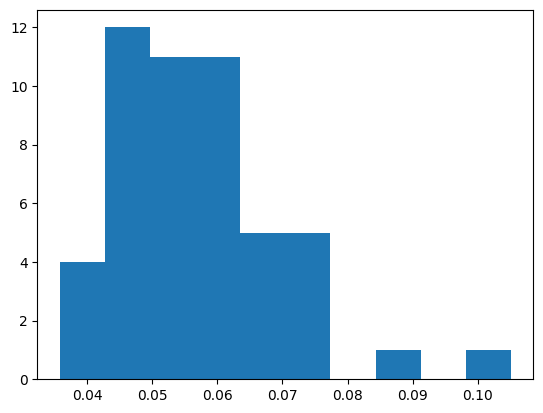

Stock Ticker:  10%|█         | 50/492 [44:30<3:49:37, 31.17s/it]

company number:  51
Train RMSE: 0.008


Stock Ticker:  10%|█         | 51/492 [44:40<3:01:29, 24.69s/it]

Test RMSE: 0.048
2680.463006734848
company number:  52
Train RMSE: 0.015


Stock Ticker:  11%|█         | 52/492 [44:50<2:28:19, 20.23s/it]

Test RMSE: 0.055
2690.2651426792145
company number:  53
Train RMSE: 0.011


Stock Ticker:  11%|█         | 53/492 [45:04<2:15:18, 18.49s/it]

Test RMSE: 0.059
2704.7182261943817
company number:  54
Train RMSE: 0.022


Stock Ticker:  11%|█         | 54/492 [50:00<12:22:58, 101.78s/it]

Test RMSE: 0.096
3000.82599067688
company number:  55
Train RMSE: 0.016


Stock Ticker:  11%|█         | 55/492 [54:25<18:16:29, 150.55s/it]

Test RMSE: 0.056
3265.1704699993134
company number:  56
Train RMSE: 0.007


Stock Ticker:  11%|█▏        | 56/492 [59:06<22:58:04, 189.64s/it]

Test RMSE: 0.053
3546.035950422287
company number:  57
Train RMSE: 0.017


Stock Ticker:  12%|█▏        | 57/492 [1:04:22<27:31:45, 227.83s/it]

Test RMSE: 0.056
3862.963926553726
company number:  58
Train RMSE: 0.022


Stock Ticker:  12%|█▏        | 58/492 [1:08:59<29:14:08, 242.51s/it]

Test RMSE: 0.076
4139.72602725029
company number:  59
Train RMSE: 0.014


Stock Ticker:  12%|█▏        | 59/492 [1:11:50<26:34:16, 220.92s/it]

Test RMSE: 0.045
4310.261942386627
company number:  60
Train RMSE: 0.013


Stock Ticker:  12%|█▏        | 60/492 [1:11:59<18:53:58, 157.50s/it]

Test RMSE: 0.096
4319.775930643082
company number:  61
Train RMSE: 0.016


Stock Ticker:  12%|█▏        | 61/492 [1:12:07<13:29:27, 112.69s/it]

Test RMSE: 0.104
4327.902010202408
company number:  62
Train RMSE: 0.014


Stock Ticker:  13%|█▎        | 62/492 [1:12:16<9:43:44, 81.45s/it]  

Test RMSE: 0.068
4336.478489637375
company number:  63
Train RMSE: 0.009


Stock Ticker:  13%|█▎        | 63/492 [1:12:26<7:08:36, 59.95s/it]

Test RMSE: 0.075
4346.243896245956
company number:  64
Train RMSE: 0.014


Stock Ticker:  13%|█▎        | 64/492 [1:12:35<5:19:32, 44.79s/it]

Test RMSE: 0.069
4355.684195995331
company number:  65
Train RMSE: 0.027


Stock Ticker:  13%|█▎        | 65/492 [1:13:46<6:14:56, 52.69s/it]

Test RMSE: 0.092
4426.780507802963
company number:  66
Train RMSE: 0.012


Stock Ticker:  13%|█▎        | 66/492 [1:18:35<14:37:15, 123.56s/it]

Test RMSE: 0.049
4715.710196256638
company number:  67
Train RMSE: 0.011


Stock Ticker:  14%|█▎        | 67/492 [1:20:14<13:41:40, 116.00s/it]

Test RMSE: 0.051
4814.077639102936
company number:  68
Train RMSE: 0.016


Stock Ticker:  14%|█▍        | 68/492 [1:20:22<9:51:47, 83.74s/it]  

Test RMSE: 0.085
4822.553286552429
company number:  69
Train RMSE: 0.027


Stock Ticker:  14%|█▍        | 69/492 [1:20:30<7:10:56, 61.13s/it]

Test RMSE: 0.089
4830.90608048439
company number:  70
Train RMSE: 0.016


Stock Ticker:  14%|█▍        | 70/492 [1:20:39<5:19:29, 45.43s/it]

Test RMSE: 0.065
4839.696417093277
company number:  71
Train RMSE: 0.020


Stock Ticker:  14%|█▍        | 71/492 [1:20:48<4:01:03, 34.36s/it]

Test RMSE: 0.086
4848.224070310593
company number:  72
Train RMSE: 0.031


Stock Ticker:  15%|█▍        | 72/492 [1:21:01<3:17:10, 28.17s/it]

Test RMSE: 0.067
4861.952360153198
company number:  73
Train RMSE: 0.017


Stock Ticker:  15%|█▍        | 73/492 [1:22:06<4:32:55, 39.08s/it]

Test RMSE: 0.052
4926.503580331802
company number:  74
Train RMSE: 0.031


Stock Ticker:  15%|█▌        | 74/492 [1:26:21<12:02:56, 103.77s/it]

Test RMSE: 0.071
5181.218003749847
company number:  75
Train RMSE: 0.018


Stock Ticker:  15%|█▌        | 75/492 [1:28:09<12:10:17, 105.08s/it]

Test RMSE: 0.066
5289.339371442795
company number:  76
Train RMSE: 0.008


Stock Ticker:  15%|█▌        | 76/492 [1:28:18<8:48:08, 76.17s/it]  

Test RMSE: 0.053
5298.074882268906
company number:  77
Train RMSE: 0.016


Stock Ticker:  16%|█▌        | 77/492 [1:28:30<6:35:17, 57.15s/it]

Test RMSE: 0.049
5310.833612680435
company number:  78
Train RMSE: 0.015


Stock Ticker:  16%|█▌        | 78/492 [1:28:40<4:55:53, 42.88s/it]

Test RMSE: 0.056
5320.43047952652
company number:  79
Train RMSE: 0.008


Stock Ticker:  16%|█▌        | 79/492 [1:28:49<3:44:54, 32.67s/it]

Test RMSE: 0.052
5329.280636787415
company number:  80
Train RMSE: 0.024


Stock Ticker:  16%|█▋        | 80/492 [1:29:01<3:01:58, 26.50s/it]

Test RMSE: 0.063
5341.3769743442535
company number:  81
Train RMSE: 0.016


Stock Ticker:  16%|█▋        | 81/492 [1:29:12<2:29:18, 21.80s/it]

Test RMSE: 0.054
5352.199878454208
company number:  82
Train RMSE: 0.030


Stock Ticker:  17%|█▋        | 82/492 [1:29:21<2:02:34, 17.94s/it]

Test RMSE: 0.053
5361.133265018463
company number:  83
Train RMSE: 0.013


Stock Ticker:  17%|█▋        | 83/492 [1:29:28<1:41:38, 14.91s/it]

Test RMSE: 0.064
5368.978539466858
company number:  84
Train RMSE: 0.010


Stock Ticker:  17%|█▋        | 84/492 [1:29:37<1:28:01, 12.94s/it]

Test RMSE: 0.052
5377.3367574214935
company number:  85
Train RMSE: 0.033


Stock Ticker:  17%|█▋        | 85/492 [1:29:46<1:19:39, 11.74s/it]

Test RMSE: 0.064
5386.27886390686
company number:  86
Train RMSE: 0.025


Stock Ticker:  17%|█▋        | 86/492 [1:29:56<1:16:46, 11.35s/it]

Test RMSE: 0.065
5396.6952702999115
company number:  87
Train RMSE: 0.012


Stock Ticker:  18%|█▊        | 87/492 [1:30:06<1:13:09, 10.84s/it]

Test RMSE: 0.051
5406.346399307251
company number:  88
Train RMSE: 0.029


Stock Ticker:  18%|█▊        | 88/492 [1:30:14<1:08:12, 10.13s/it]

Test RMSE: 0.087
5414.823719739914
company number:  89
Train RMSE: 0.017


Stock Ticker:  18%|█▊        | 89/492 [1:30:23<1:04:51,  9.66s/it]

Test RMSE: 0.091
5423.379348278046
company number:  90
Train RMSE: 0.010


Stock Ticker:  18%|█▊        | 90/492 [1:30:31<1:02:22,  9.31s/it]

Test RMSE: 0.062
5431.8761212825775
company number:  91
Train RMSE: 0.006


Stock Ticker:  18%|█▊        | 91/492 [1:30:40<1:00:17,  9.02s/it]

Test RMSE: 0.047
5440.223167657852
company number:  92
Train RMSE: 0.014


Stock Ticker:  19%|█▊        | 92/492 [1:30:49<1:00:26,  9.07s/it]

Test RMSE: 0.062
5449.39616727829
company number:  93
Train RMSE: 0.027


Stock Ticker:  19%|█▉        | 93/492 [1:30:57<58:15,  8.76s/it]  

Test RMSE: 0.094
5457.444746494293
company number:  94
Train RMSE: 0.015


Stock Ticker:  19%|█▉        | 94/492 [1:31:13<1:12:55, 10.99s/it]

Test RMSE: 0.074
5473.644304513931
company number:  95
Train RMSE: 0.027


Stock Ticker:  19%|█▉        | 95/492 [1:35:52<10:04:08, 91.31s/it]

Test RMSE: 0.120
5752.351009607315
company number:  96
Train RMSE: 0.018


Stock Ticker:  20%|█▉        | 96/492 [1:36:00<7:18:17, 66.41s/it] 

Test RMSE: 0.082
5760.659407377243
company number:  97
Train RMSE: 0.021


Stock Ticker:  20%|█▉        | 97/492 [1:37:00<7:03:53, 64.39s/it]

Test RMSE: 0.146
5820.337349176407
company number:  98
Train RMSE: 0.015


Stock Ticker:  20%|█▉        | 98/492 [1:41:55<14:38:20, 133.76s/it]

Test RMSE: 0.073
6115.955131053925
company number:  99
Train RMSE: 0.012


Stock Ticker:  20%|██        | 99/492 [1:46:34<19:19:52, 177.08s/it]

Test RMSE: 0.070
6394.1218111515045
company number:  100
Train RMSE: 0.012
Test RMSE: 0.047
6466.948233604431


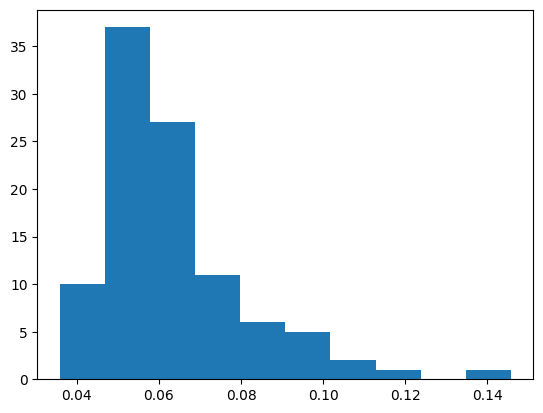

Stock Ticker:  20%|██        | 100/492 [1:47:47<15:52:42, 145.82s/it]

company number:  101
Train RMSE: 0.022


Stock Ticker:  21%|██        | 101/492 [1:47:55<11:20:53, 104.48s/it]

Test RMSE: 0.095
6475.0390293598175
company number:  102
Train RMSE: 0.010


Stock Ticker:  21%|██        | 102/492 [1:48:03<8:12:42, 75.80s/it]  

Test RMSE: 0.047
6483.9130423069
company number:  103
Train RMSE: 0.020


Stock Ticker:  21%|██        | 103/492 [1:48:12<6:01:22, 55.74s/it]

Test RMSE: 0.079
6492.843759059906
company number:  104
Train RMSE: 0.009


Stock Ticker:  21%|██        | 104/492 [1:48:22<4:31:07, 41.93s/it]

Test RMSE: 0.056
6502.537443399429
company number:  105
Train RMSE: 0.020


Stock Ticker:  21%|██▏       | 105/492 [1:50:22<7:01:00, 65.27s/it]

Test RMSE: 0.074
6622.282356262207
company number:  106
Train RMSE: 0.011


Stock Ticker:  22%|██▏       | 106/492 [1:55:27<14:43:43, 137.37s/it]

Test RMSE: 0.045
6927.871697425842
company number:  107
Train RMSE: 0.008


Stock Ticker:  22%|██▏       | 107/492 [2:00:26<19:52:44, 185.88s/it]

Test RMSE: 0.056
7226.954265594482
company number:  108
Train RMSE: 0.019


Stock Ticker:  22%|██▏       | 108/492 [2:05:49<24:12:06, 226.89s/it]

Test RMSE: 0.074
7549.53745675087
company number:  109
Train RMSE: 0.017


Stock Ticker:  22%|██▏       | 109/492 [2:11:27<27:40:24, 260.12s/it]

Test RMSE: 0.060
7887.179186344147
company number:  110
Train RMSE: 0.016


Stock Ticker:  22%|██▏       | 110/492 [2:16:27<28:52:31, 272.13s/it]

Test RMSE: 0.057
8187.32408285141
company number:  111
Train RMSE: 0.019


Stock Ticker:  23%|██▎       | 111/492 [2:20:47<28:25:54, 268.65s/it]

Test RMSE: 0.056
8447.853055477142
company number:  112
Train RMSE: 0.009


Stock Ticker:  23%|██▎       | 112/492 [2:25:37<29:01:53, 275.04s/it]

Test RMSE: 0.082
8737.797468662262
company number:  113
Train RMSE: 0.014


Stock Ticker:  23%|██▎       | 113/492 [2:26:43<22:20:19, 212.19s/it]

Test RMSE: 0.050
8803.34226346016
company number:  114
Train RMSE: 0.012


Stock Ticker:  23%|██▎       | 114/492 [2:31:24<24:26:28, 232.77s/it]

Test RMSE: 0.061
9084.149832963943
company number:  115
Train RMSE: 0.019


Stock Ticker:  23%|██▎       | 115/492 [2:35:32<24:52:48, 237.58s/it]

Test RMSE: 0.041
9332.948689937592
company number:  116
Train RMSE: 0.021


Stock Ticker:  24%|██▎       | 116/492 [2:40:13<26:10:09, 250.56s/it]

Test RMSE: 0.079
9613.783368349075
company number:  117
Train RMSE: 0.014


Stock Ticker:  24%|██▍       | 117/492 [2:43:51<25:04:47, 240.77s/it]

Test RMSE: 0.058
9831.706318378448
company number:  118
Train RMSE: 0.016


Stock Ticker:  24%|██▍       | 118/492 [2:50:06<29:11:53, 281.05s/it]

Test RMSE: 0.047
10206.753851890564
company number:  119
Train RMSE: 0.019


Stock Ticker:  24%|██▍       | 119/492 [2:54:56<29:23:46, 283.72s/it]

Test RMSE: 0.081
10496.694077014923
company number:  120
Train RMSE: 0.023


Stock Ticker:  24%|██▍       | 120/492 [2:59:09<28:20:42, 274.31s/it]

Test RMSE: 0.078
10749.044929742813
company number:  121
Train RMSE: 0.020


Stock Ticker:  25%|██▍       | 121/492 [3:04:57<30:33:44, 296.56s/it]

Test RMSE: 0.062
11097.535996198654
company number:  122
Train RMSE: 0.020


Stock Ticker:  25%|██▍       | 122/492 [3:09:46<30:15:02, 294.33s/it]

Test RMSE: 0.061
11386.65895986557
company number:  123
Train RMSE: 0.021


Stock Ticker:  25%|██▌       | 123/492 [3:15:38<31:55:23, 311.45s/it]

Test RMSE: 0.050
11738.04201889038
company number:  124
Train RMSE: 0.013


Stock Ticker:  25%|██▌       | 124/492 [3:15:47<22:34:43, 220.88s/it]

Test RMSE: 0.040
11747.593445777893
company number:  125
Train RMSE: 0.017


Stock Ticker:  25%|██▌       | 125/492 [3:15:55<16:00:48, 157.08s/it]

Test RMSE: 0.091
11755.811452627182
company number:  126
Train RMSE: 0.012


Stock Ticker:  26%|██▌       | 126/492 [3:16:05<11:27:49, 112.76s/it]

Test RMSE: 0.056
11765.152019500732
company number:  127


Stock Ticker:  26%|██▌       | 127/492 [3:16:06<8:02:29, 79.31s/it]  

Train RMSE: 0.113
Test RMSE: 0.124
11766.428488016129
company number:  128
Train RMSE: 0.010


Stock Ticker:  26%|██▌       | 128/492 [3:16:14<5:52:13, 58.06s/it]

Test RMSE: 0.061
11774.893015861511
company number:  129
Train RMSE: 0.007


Stock Ticker:  26%|██▌       | 129/492 [3:16:23<4:21:05, 43.16s/it]

Test RMSE: 0.038
11783.276631832123
company number:  130
Train RMSE: 0.018


Stock Ticker:  26%|██▋       | 130/492 [3:16:32<3:19:23, 33.05s/it]

Test RMSE: 0.062
11792.743168592453
company number:  131
Train RMSE: 0.016


Stock Ticker:  27%|██▋       | 131/492 [3:16:45<2:42:45, 27.05s/it]

Test RMSE: 0.080
11805.795732021332
company number:  132
Train RMSE: 0.012


Stock Ticker:  27%|██▋       | 132/492 [3:16:54<2:09:18, 21.55s/it]

Test RMSE: 0.067
11814.514633893967
company number:  133
Train RMSE: 0.012


Stock Ticker:  27%|██▋       | 133/492 [3:17:02<1:45:26, 17.62s/it]

Test RMSE: 0.071
11822.967773199081
company number:  134
Train RMSE: 0.018


Stock Ticker:  27%|██▋       | 134/492 [3:17:11<1:29:30, 15.00s/it]

Test RMSE: 0.061
11831.856499433517
company number:  135
Train RMSE: 0.011


Stock Ticker:  27%|██▋       | 135/492 [3:17:20<1:17:45, 13.07s/it]

Test RMSE: 0.063
11840.414801597595
company number:  136
Train RMSE: 0.024


Stock Ticker:  28%|██▊       | 136/492 [3:17:29<1:10:00, 11.80s/it]

Test RMSE: 0.072
11849.251623153687
company number:  137
Train RMSE: 0.019


Stock Ticker:  28%|██▊       | 137/492 [3:17:38<1:04:42, 10.94s/it]

Test RMSE: 0.078
11858.174389123917
company number:  138
Train RMSE: 0.019


Stock Ticker:  28%|██▊       | 138/492 [3:17:45<58:51,  9.98s/it]  

Test RMSE: 0.069
11865.907361507416
company number:  139
Train RMSE: 0.010


Stock Ticker:  28%|██▊       | 139/492 [3:17:55<57:57,  9.85s/it]

Test RMSE: 0.058
11875.465403795242
company number:  140
Train RMSE: 0.017


Stock Ticker:  28%|██▊       | 140/492 [3:18:03<53:47,  9.17s/it]

Test RMSE: 0.082
11883.043362855911
company number:  141
Train RMSE: 0.022


Stock Ticker:  29%|██▊       | 141/492 [3:18:11<52:08,  8.91s/it]

Test RMSE: 0.077
11891.356435537338
company number:  142
Train RMSE: 0.016


Stock Ticker:  29%|██▉       | 142/492 [3:18:19<50:16,  8.62s/it]

Test RMSE: 0.052
11899.295236825943
company number:  143
Train RMSE: 0.008


Stock Ticker:  29%|██▉       | 143/492 [3:18:27<48:56,  8.41s/it]

Test RMSE: 0.075
11907.227888584137
company number:  144
Train RMSE: 0.027


Stock Ticker:  29%|██▉       | 144/492 [3:18:33<45:13,  7.80s/it]

Test RMSE: 0.075
11913.589950323105
company number:  145
Train RMSE: 0.019


Stock Ticker:  29%|██▉       | 145/492 [3:18:42<46:44,  8.08s/it]

Test RMSE: 0.081
11922.33572602272
company number:  146
Train RMSE: 0.011


Stock Ticker:  30%|██▉       | 146/492 [3:18:51<48:17,  8.37s/it]

Test RMSE: 0.047
11931.393138885498
company number:  147
Train RMSE: 0.007


Stock Ticker:  30%|██▉       | 147/492 [3:19:00<49:56,  8.69s/it]

Test RMSE: 0.037
11940.804179906845
company number:  148
Train RMSE: 0.023


Stock Ticker:  30%|███       | 148/492 [3:19:11<53:42,  9.37s/it]

Test RMSE: 0.122
11951.75953412056
company number:  149
Train RMSE: 0.023


Stock Ticker:  30%|███       | 149/492 [3:19:22<55:02,  9.63s/it]

Test RMSE: 0.056
11962.002213716507
company number:  150
Train RMSE: 0.024
Test RMSE: 0.099
11969.59874534607


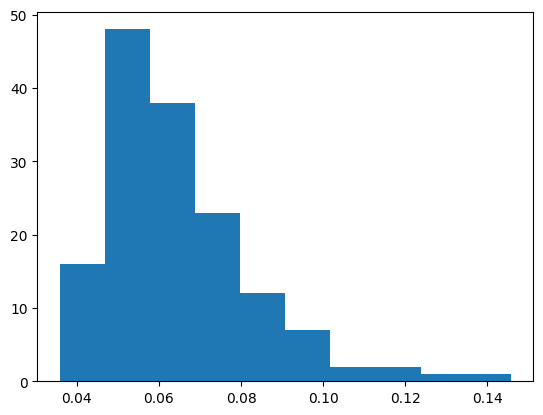

Stock Ticker:  30%|███       | 150/492 [3:19:29<51:30,  9.04s/it]

company number:  151
Train RMSE: 0.011


Stock Ticker:  31%|███       | 151/492 [3:19:38<50:11,  8.83s/it]

Test RMSE: 0.051
11978.012588977814
company number:  152
Train RMSE: 0.045


Stock Ticker:  31%|███       | 152/492 [3:19:40<38:47,  6.84s/it]

Test RMSE: 0.100
11980.217038869858
company number:  153
Train RMSE: 0.020


Stock Ticker:  31%|███       | 153/492 [3:19:50<45:19,  8.02s/it]

Test RMSE: 0.063
11990.98718380928
company number:  154
Train RMSE: 0.017


Stock Ticker:  31%|███▏      | 154/492 [3:22:49<5:33:16, 59.16s/it]

Test RMSE: 0.052
12169.473769187927
company number:  155
Train RMSE: 0.018


Stock Ticker:  32%|███▏      | 155/492 [3:25:55<9:06:08, 97.24s/it]

Test RMSE: 0.058
12355.54885339737
company number:  156
Train RMSE: 0.014


Stock Ticker:  32%|███▏      | 156/492 [3:30:18<13:42:36, 146.89s/it]

Test RMSE: 0.058
12618.310868501663
company number:  157
Train RMSE: 0.011


Stock Ticker:  32%|███▏      | 157/492 [3:34:55<17:18:17, 185.96s/it]

Test RMSE: 0.051
12895.436528205872
company number:  158
Train RMSE: 0.014


Stock Ticker:  32%|███▏      | 158/492 [3:39:59<20:32:52, 221.47s/it]

Test RMSE: 0.070
13199.766528129578
company number:  159
Train RMSE: 0.010


Stock Ticker:  32%|███▏      | 159/492 [3:44:20<21:34:29, 233.24s/it]

Test RMSE: 0.065
13460.468870162964
company number:  160
Train RMSE: 0.011


Stock Ticker:  33%|███▎      | 160/492 [3:48:30<21:58:04, 238.21s/it]

Test RMSE: 0.053
13710.25617814064
company number:  161
Train RMSE: 0.042


Stock Ticker:  33%|███▎      | 161/492 [3:54:14<24:50:00, 270.09s/it]

Test RMSE: 0.084
14054.746912956238
company number:  162
Train RMSE: 0.012


Stock Ticker:  33%|███▎      | 162/492 [3:55:01<18:36:39, 203.03s/it]

Test RMSE: 0.055
14101.29361820221
company number:  163
Train RMSE: 0.015


Stock Ticker:  33%|███▎      | 163/492 [3:55:10<13:14:51, 144.96s/it]

Test RMSE: 0.029
14110.755707263947
company number:  164
Train RMSE: 0.014


Stock Ticker:  33%|███▎      | 164/492 [3:55:20<9:30:45, 104.41s/it] 

Test RMSE: 0.077
14120.540087461472
company number:  165
Train RMSE: 0.011


Stock Ticker:  34%|███▎      | 165/492 [3:55:29<6:52:48, 75.75s/it] 

Test RMSE: 0.048
14129.412177085876
company number:  166
Train RMSE: 0.015


Stock Ticker:  34%|███▎      | 166/492 [3:55:38<5:02:46, 55.73s/it]

Test RMSE: 0.070
14138.427967309952
company number:  167
Train RMSE: 0.010


Stock Ticker:  34%|███▍      | 167/492 [3:55:52<3:54:06, 43.22s/it]

Test RMSE: 0.076
14152.466384649277
company number:  168
Train RMSE: 0.010


Stock Ticker:  34%|███▍      | 168/492 [3:56:03<3:01:06, 33.54s/it]

Test RMSE: 0.042
14163.411854028702
company number:  169
Train RMSE: 0.012


Stock Ticker:  34%|███▍      | 169/492 [3:56:12<2:20:44, 26.14s/it]

Test RMSE: 0.050
14172.301196575165
company number:  170
Train RMSE: 0.008


Stock Ticker:  35%|███▍      | 170/492 [3:56:21<1:53:23, 21.13s/it]

Test RMSE: 0.075
14181.733382940292
company number:  171
Train RMSE: 0.018


Stock Ticker:  35%|███▍      | 171/492 [3:56:33<1:38:12, 18.36s/it]

Test RMSE: 0.033
14193.620486021042
company number:  172
Train RMSE: 0.020


Stock Ticker:  35%|███▍      | 172/492 [3:56:43<1:24:03, 15.76s/it]

Test RMSE: 0.060
14203.319632530212
company number:  173
Train RMSE: 0.009


Stock Ticker:  35%|███▌      | 173/492 [3:56:53<1:14:12, 13.96s/it]

Test RMSE: 0.060
14213.070713758469
company number:  174
Train RMSE: 0.009


Stock Ticker:  35%|███▌      | 174/492 [3:57:03<1:08:23, 12.90s/it]

Test RMSE: 0.047
14223.516046762466
company number:  175
Train RMSE: 0.014


Stock Ticker:  36%|███▌      | 175/492 [3:57:12<1:02:38, 11.86s/it]

Test RMSE: 0.049
14232.932886362076
company number:  176
Train RMSE: 0.011


Stock Ticker:  36%|███▌      | 176/492 [3:57:22<58:05, 11.03s/it]  

Test RMSE: 0.057
14242.031737565994
company number:  177
Train RMSE: 0.015


Stock Ticker:  36%|███▌      | 177/492 [3:57:31<54:58, 10.47s/it]

Test RMSE: 0.066
14251.202481746674
company number:  178
Train RMSE: 0.014


Stock Ticker:  36%|███▌      | 178/492 [3:57:39<51:11,  9.78s/it]

Test RMSE: 0.067
14259.368746757507
company number:  179
Train RMSE: 0.018


Stock Ticker:  36%|███▋      | 179/492 [3:57:48<49:52,  9.56s/it]

Test RMSE: 0.054
14268.422091007233
company number:  180
Train RMSE: 0.009


Stock Ticker:  37%|███▋      | 180/492 [3:57:58<51:09,  9.84s/it]

Test RMSE: 0.039
14278.905319929123
company number:  181
Train RMSE: 0.016


Stock Ticker:  37%|███▋      | 181/492 [3:58:06<47:20,  9.13s/it]

Test RMSE: 0.074
14286.393011569977
company number:  182
Train RMSE: 0.023


Stock Ticker:  37%|███▋      | 182/492 [3:58:15<46:58,  9.09s/it]

Test RMSE: 0.197
14295.38865017891
company number:  183
Train RMSE: 0.019


Stock Ticker:  37%|███▋      | 183/492 [3:58:23<44:49,  8.70s/it]

Test RMSE: 0.091
14303.185168504715
company number:  184
Train RMSE: 0.010


Stock Ticker:  37%|███▋      | 184/492 [3:58:31<43:39,  8.50s/it]

Test RMSE: 0.053
14311.225126981735
company number:  185
Train RMSE: 0.023


Stock Ticker:  38%|███▊      | 185/492 [3:58:40<44:17,  8.66s/it]

Test RMSE: 0.082
14320.23969244957
company number:  186
Train RMSE: 0.017


Stock Ticker:  38%|███▊      | 186/492 [3:58:48<43:45,  8.58s/it]

Test RMSE: 0.054
14328.640310525894
company number:  187
Train RMSE: 0.013


Stock Ticker:  38%|███▊      | 187/492 [3:58:57<44:28,  8.75s/it]

Test RMSE: 0.072
14337.78329706192
company number:  188
Train RMSE: 0.008


Stock Ticker:  38%|███▊      | 188/492 [3:59:06<44:47,  8.84s/it]

Test RMSE: 0.067
14346.83895277977
company number:  189
Train RMSE: 0.021


Stock Ticker:  38%|███▊      | 189/492 [3:59:15<44:28,  8.81s/it]

Test RMSE: 0.112
14355.564610004425
company number:  190
Train RMSE: 0.020


Stock Ticker:  39%|███▊      | 190/492 [3:59:26<47:27,  9.43s/it]

Test RMSE: 0.072
14366.441280603409
company number:  191
Train RMSE: 0.014


Stock Ticker:  39%|███▉      | 191/492 [3:59:34<45:40,  9.10s/it]

Test RMSE: 0.065
14374.786722183228
company number:  192
Train RMSE: 0.009


Stock Ticker:  39%|███▉      | 192/492 [3:59:44<46:01,  9.20s/it]

Test RMSE: 0.064
14384.23013973236
company number:  193
Train RMSE: 0.016


Stock Ticker:  39%|███▉      | 193/492 [3:59:53<45:38,  9.16s/it]

Test RMSE: 0.061
14393.284301042557
company number:  194
Train RMSE: 0.015


Stock Ticker:  39%|███▉      | 194/492 [4:00:04<48:35,  9.78s/it]

Test RMSE: 0.062
14404.5205783844
company number:  195
Train RMSE: 0.011


Stock Ticker:  40%|███▉      | 195/492 [4:00:12<45:52,  9.27s/it]

Test RMSE: 0.043
14412.583905696869
company number:  196
Train RMSE: 0.008


Stock Ticker:  40%|███▉      | 196/492 [4:00:21<45:27,  9.21s/it]

Test RMSE: 0.056
14421.677643060684
company number:  197
Train RMSE: 0.011


Stock Ticker:  40%|████      | 197/492 [4:00:31<45:49,  9.32s/it]

Test RMSE: 0.065
14431.241062402725
company number:  198
Train RMSE: 0.014


Stock Ticker:  40%|████      | 198/492 [4:00:40<45:01,  9.19s/it]

Test RMSE: 0.060
14440.119784593582
company number:  199
Train RMSE: 0.018


Stock Ticker:  40%|████      | 199/492 [4:00:49<45:18,  9.28s/it]

Test RMSE: 0.056
14449.613204956055
company number:  200
Train RMSE: 0.014
Test RMSE: 0.078
14459.171787023544


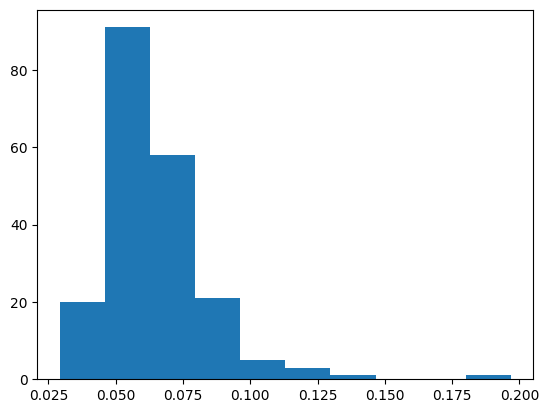

Stock Ticker:  41%|████      | 200/492 [4:00:59<45:39,  9.38s/it]

company number:  201
Train RMSE: 0.054


Stock Ticker:  41%|████      | 201/492 [4:01:01<35:14,  7.27s/it]

Test RMSE: 0.072
14461.569673776627
company number:  202
Train RMSE: 0.047


Stock Ticker:  41%|████      | 202/492 [4:01:03<27:51,  5.76s/it]

Test RMSE: 0.073
14463.826717853546
company number:  203
Train RMSE: 0.020


Stock Ticker:  41%|████▏     | 203/492 [4:01:13<33:20,  6.92s/it]

Test RMSE: 0.067
14473.448791742325
company number:  204
Train RMSE: 0.010


Stock Ticker:  41%|████▏     | 204/492 [4:01:21<35:08,  7.32s/it]

Test RMSE: 0.049
14481.704971075058
company number:  205
Train RMSE: 0.009


Stock Ticker:  42%|████▏     | 205/492 [4:01:30<36:29,  7.63s/it]

Test RMSE: 0.060
14490.055449724197
company number:  206
Train RMSE: 0.016


Stock Ticker:  42%|████▏     | 206/492 [4:01:39<38:32,  8.09s/it]

Test RMSE: 0.060
14499.201150894165
company number:  207
Train RMSE: 0.019


Stock Ticker:  42%|████▏     | 207/492 [4:01:48<40:20,  8.49s/it]

Test RMSE: 0.050
14508.64482665062
company number:  208
Train RMSE: 0.015


Stock Ticker:  42%|████▏     | 208/492 [4:01:57<40:16,  8.51s/it]

Test RMSE: 0.043
14517.186902046204
company number:  209
Train RMSE: 0.006


Stock Ticker:  42%|████▏     | 209/492 [4:02:04<39:02,  8.28s/it]

Test RMSE: 0.058
14524.922968864441
company number:  210
Train RMSE: 0.015


Stock Ticker:  43%|████▎     | 210/492 [4:02:13<38:40,  8.23s/it]

Test RMSE: 0.048
14533.039044618607
company number:  211
Train RMSE: 0.015


Stock Ticker:  43%|████▎     | 211/492 [4:02:21<39:29,  8.43s/it]

Test RMSE: 0.055
14541.952155590057
company number:  212
Train RMSE: 0.021


Stock Ticker:  43%|████▎     | 212/492 [4:02:31<41:11,  8.83s/it]

Test RMSE: 0.081
14551.701849937439
company number:  213
Train RMSE: 0.012


Stock Ticker:  43%|████▎     | 213/492 [4:02:40<40:50,  8.78s/it]

Test RMSE: 0.077
14560.380313396454
company number:  214
Train RMSE: 0.013


Stock Ticker:  43%|████▎     | 214/492 [4:02:49<41:41,  9.00s/it]

Test RMSE: 0.081
14569.884423494339
company number:  215
Train RMSE: 0.008


Stock Ticker:  44%|████▎     | 215/492 [4:02:57<39:41,  8.60s/it]

Test RMSE: 0.047
14577.548593044281
company number:  216
Train RMSE: 0.013


Stock Ticker:  44%|████▍     | 216/492 [4:03:07<40:58,  8.91s/it]

Test RMSE: 0.042
14587.18059706688
company number:  217
Train RMSE: 0.016


Stock Ticker:  44%|████▍     | 217/492 [4:03:17<42:12,  9.21s/it]

Test RMSE: 0.045
14597.089013338089
company number:  218
Train RMSE: 0.008


Stock Ticker:  44%|████▍     | 218/492 [4:03:24<39:54,  8.74s/it]

Test RMSE: 0.029
14604.728493452072
company number:  219
Train RMSE: 0.010


Stock Ticker:  45%|████▍     | 219/492 [4:03:33<39:13,  8.62s/it]

Test RMSE: 0.059
14613.074628591537
company number:  220
Train RMSE: 0.015


Stock Ticker:  45%|████▍     | 220/492 [4:03:41<39:25,  8.70s/it]

Test RMSE: 0.108
14621.953124284744
company number:  221
Train RMSE: 0.018


Stock Ticker:  45%|████▍     | 221/492 [4:03:50<39:00,  8.64s/it]

Test RMSE: 0.066
14630.445385932922
company number:  222
Train RMSE: 0.011


Stock Ticker:  45%|████▌     | 222/492 [4:04:00<41:15,  9.17s/it]

Test RMSE: 0.058
14640.851407051086
company number:  223
Train RMSE: 0.017


Stock Ticker:  45%|████▌     | 223/492 [4:04:09<40:17,  8.99s/it]

Test RMSE: 0.082
14649.415928840637
company number:  224
Train RMSE: 0.010


Stock Ticker:  46%|████▌     | 224/492 [4:04:18<40:07,  8.98s/it]

Test RMSE: 0.047
14658.397096633911
company number:  225
Train RMSE: 0.019


Stock Ticker:  46%|████▌     | 225/492 [4:04:26<38:39,  8.69s/it]

Test RMSE: 0.079
14666.394608259201
company number:  226
Train RMSE: 0.013


Stock Ticker:  46%|████▌     | 226/492 [4:04:35<38:32,  8.69s/it]

Test RMSE: 0.085
14675.098665475845
company number:  227
Train RMSE: 0.009


Stock Ticker:  46%|████▌     | 227/492 [4:04:43<38:18,  8.67s/it]

Test RMSE: 0.050
14683.720497846603
company number:  228
Train RMSE: 0.013


Stock Ticker:  46%|████▋     | 228/492 [4:04:52<38:40,  8.79s/it]

Test RMSE: 0.072
14692.788169145584
company number:  229
Train RMSE: 0.011


Stock Ticker:  47%|████▋     | 229/492 [4:05:01<38:47,  8.85s/it]

Test RMSE: 0.060
14701.780310153961
company number:  230
Train RMSE: 0.015


Stock Ticker:  47%|████▋     | 230/492 [4:05:11<39:08,  8.96s/it]

Test RMSE: 0.062
14711.005649328232
company number:  231
Train RMSE: 0.012


Stock Ticker:  47%|████▋     | 231/492 [4:05:19<38:06,  8.76s/it]

Test RMSE: 0.065
14719.296476364136
company number:  232
Train RMSE: 0.024


Stock Ticker:  47%|████▋     | 232/492 [4:05:29<40:00,  9.23s/it]

Test RMSE: 0.060
14729.625007867813
company number:  233
Train RMSE: 0.014


Stock Ticker:  47%|████▋     | 233/492 [4:05:38<39:27,  9.14s/it]

Test RMSE: 0.048
14738.558241844177
company number:  234
Train RMSE: 0.017


Stock Ticker:  48%|████▊     | 234/492 [4:05:47<38:41,  9.00s/it]

Test RMSE: 0.063
14747.221000671387
company number:  235
Train RMSE: 0.014


Stock Ticker:  48%|████▊     | 235/492 [4:05:57<39:46,  9.29s/it]

Test RMSE: 0.051
14757.177538394928
company number:  236
Train RMSE: 0.015


Stock Ticker:  48%|████▊     | 236/492 [4:06:07<40:20,  9.46s/it]

Test RMSE: 0.066
14767.03317284584
company number:  237
Train RMSE: 0.019


Stock Ticker:  48%|████▊     | 237/492 [4:06:16<40:06,  9.44s/it]

Test RMSE: 0.064
14776.420984983444
company number:  238
Train RMSE: 0.019


Stock Ticker:  48%|████▊     | 238/492 [4:06:25<39:59,  9.45s/it]

Test RMSE: 0.066
14785.889690637589
company number:  239
Train RMSE: 0.013


Stock Ticker:  49%|████▊     | 239/492 [4:06:35<40:13,  9.54s/it]

Test RMSE: 0.054
14795.644869565964
company number:  240
Train RMSE: 0.012


Stock Ticker:  49%|████▉     | 240/492 [4:06:44<38:37,  9.20s/it]

Test RMSE: 0.066
14804.043407440186
company number:  241
Train RMSE: 0.016


Stock Ticker:  49%|████▉     | 241/492 [4:06:53<38:51,  9.29s/it]

Test RMSE: 0.080
14813.548707723618
company number:  242
Train RMSE: 0.013


Stock Ticker:  49%|████▉     | 242/492 [4:07:02<37:46,  9.07s/it]

Test RMSE: 0.070
14822.0916492939
company number:  243
Train RMSE: 0.020


Stock Ticker:  49%|████▉     | 243/492 [4:07:11<37:32,  9.05s/it]

Test RMSE: 0.075
14831.097680330276
company number:  244
Train RMSE: 0.014


Stock Ticker:  50%|████▉     | 244/492 [4:07:19<36:13,  8.76s/it]

Test RMSE: 0.072
14839.200741529465
company number:  245
Train RMSE: 0.018


Stock Ticker:  50%|████▉     | 245/492 [4:07:30<39:37,  9.63s/it]

Test RMSE: 0.061
14850.84039592743
company number:  246
Train RMSE: 0.010


Stock Ticker:  50%|█████     | 246/492 [4:07:40<40:07,  9.78s/it]

Test RMSE: 0.058
14860.99352145195
company number:  247
Train RMSE: 0.018


Stock Ticker:  50%|█████     | 247/492 [4:07:48<37:41,  9.23s/it]

Test RMSE: 0.085
14868.934979438782
company number:  248
Train RMSE: 0.010


Stock Ticker:  50%|█████     | 248/492 [4:07:58<37:39,  9.26s/it]

Test RMSE: 0.082
14878.267770051956
company number:  249
Train RMSE: 0.012


Stock Ticker:  51%|█████     | 249/492 [4:08:07<37:18,  9.21s/it]

Test RMSE: 0.120
14887.360466718674
company number:  250
Train RMSE: 0.014
Test RMSE: 0.049
14895.732952594757


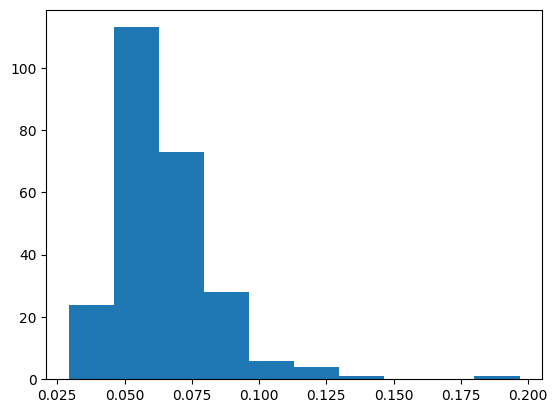

Stock Ticker:  51%|█████     | 250/492 [4:08:15<36:12,  8.98s/it]

company number:  251
Train RMSE: 0.037


Stock Ticker:  51%|█████     | 251/492 [4:08:23<34:52,  8.68s/it]

Test RMSE: 0.104
14903.785651683807
company number:  252
Train RMSE: 0.010


Stock Ticker:  51%|█████     | 252/492 [4:08:33<35:30,  8.88s/it]

Test RMSE: 0.060
14913.123225688934
company number:  253
Train RMSE: 0.016


Stock Ticker:  51%|█████▏    | 253/492 [4:08:41<34:59,  8.79s/it]

Test RMSE: 0.082
14921.694371700287
company number:  254
Train RMSE: 0.011


Stock Ticker:  52%|█████▏    | 254/492 [4:08:49<34:05,  8.59s/it]

Test RMSE: 0.035
14929.836819648743
company number:  255
Train RMSE: 0.007


Stock Ticker:  52%|█████▏    | 255/492 [4:08:58<33:30,  8.48s/it]

Test RMSE: 0.050
14938.067740917206
company number:  256
Train RMSE: 0.015


Stock Ticker:  52%|█████▏    | 256/492 [4:09:07<34:07,  8.68s/it]

Test RMSE: 0.062
14947.196516752243
company number:  257
Train RMSE: 0.028


Stock Ticker:  52%|█████▏    | 257/492 [4:09:14<32:55,  8.40s/it]

Test RMSE: 0.115
14954.964916706085
company number:  258
Train RMSE: 0.012


Stock Ticker:  52%|█████▏    | 258/492 [4:09:25<35:31,  9.11s/it]

Test RMSE: 0.058
14965.712859630585
company number:  259
Train RMSE: 0.009


Stock Ticker:  53%|█████▎    | 259/492 [4:09:34<34:50,  8.97s/it]

Test RMSE: 0.065
14974.372208118439
company number:  260
Train RMSE: 0.015


Stock Ticker:  53%|█████▎    | 260/492 [4:09:43<35:22,  9.15s/it]

Test RMSE: 0.059
14983.934413433075
company number:  261
Train RMSE: 0.010


Stock Ticker:  53%|█████▎    | 261/492 [4:09:53<35:23,  9.19s/it]

Test RMSE: 0.051
14993.219549894333
company number:  262
Train RMSE: 0.025


Stock Ticker:  53%|█████▎    | 262/492 [4:10:02<35:34,  9.28s/it]

Test RMSE: 0.112
15002.71646285057
company number:  263
Train RMSE: 0.013


Stock Ticker:  53%|█████▎    | 263/492 [4:10:10<34:01,  8.91s/it]

Test RMSE: 0.064
15010.773827552795
company number:  264
Train RMSE: 0.013


Stock Ticker:  54%|█████▎    | 264/492 [4:10:19<33:58,  8.94s/it]

Test RMSE: 0.055
15019.768691778183
company number:  265
Train RMSE: 0.016


Stock Ticker:  54%|█████▍    | 265/492 [4:10:27<32:38,  8.63s/it]

Test RMSE: 0.081
15027.675629377365
company number:  266
Train RMSE: 0.021


Stock Ticker:  54%|█████▍    | 266/492 [4:10:37<33:43,  8.96s/it]

Test RMSE: 0.049
15037.392539978027
company number:  267
Train RMSE: 0.017


Stock Ticker:  54%|█████▍    | 267/492 [4:10:43<29:56,  7.98s/it]

Test RMSE: 0.007
15043.106387138367
company number:  268
Train RMSE: 0.017


Stock Ticker:  54%|█████▍    | 268/492 [4:10:52<31:26,  8.42s/it]

Test RMSE: 0.063
15052.558919668198
company number:  269
Train RMSE: 0.008


Stock Ticker:  55%|█████▍    | 269/492 [4:11:01<32:20,  8.70s/it]

Test RMSE: 0.058
15061.9126162529
company number:  270
Train RMSE: 0.017


Stock Ticker:  55%|█████▍    | 270/492 [4:11:11<33:11,  8.97s/it]

Test RMSE: 0.084
15071.503977537155
company number:  271
Train RMSE: 0.013


Stock Ticker:  55%|█████▌    | 271/492 [4:11:21<34:15,  9.30s/it]

Test RMSE: 0.051
15081.575154066086
company number:  272
Train RMSE: 0.020


Stock Ticker:  55%|█████▌    | 272/492 [4:11:31<34:53,  9.51s/it]

Test RMSE: 0.052
15091.591421365738
company number:  273
Train RMSE: 0.011


Stock Ticker:  55%|█████▌    | 273/492 [4:11:40<33:41,  9.23s/it]

Test RMSE: 0.065
15100.153244495392
company number:  274
Train RMSE: 0.013


Stock Ticker:  56%|█████▌    | 274/492 [4:11:48<32:37,  8.98s/it]

Test RMSE: 0.030
15108.556544542313
company number:  275
Train RMSE: 0.019


Stock Ticker:  56%|█████▌    | 275/492 [4:11:56<31:15,  8.64s/it]

Test RMSE: 0.081
15116.406663417816
company number:  276
Train RMSE: 0.019


Stock Ticker:  56%|█████▌    | 276/492 [4:12:05<31:58,  8.88s/it]

Test RMSE: 0.059
15125.84926199913
company number:  277
Train RMSE: 0.017


Stock Ticker:  56%|█████▋    | 277/492 [4:12:14<31:34,  8.81s/it]

Test RMSE: 0.049
15134.491622447968
company number:  278
Train RMSE: 0.006


Stock Ticker:  57%|█████▋    | 278/492 [4:12:24<32:14,  9.04s/it]

Test RMSE: 0.065
15144.059485197067
company number:  279
Train RMSE: 0.011


Stock Ticker:  57%|█████▋    | 279/492 [4:12:33<32:19,  9.10s/it]

Test RMSE: 0.053
15153.317993879318
company number:  280
Train RMSE: 0.021


Stock Ticker:  57%|█████▋    | 280/492 [4:12:42<32:01,  9.06s/it]

Test RMSE: 0.057
15162.280876874924
company number:  281
Train RMSE: 0.008


Stock Ticker:  57%|█████▋    | 281/492 [4:12:50<30:37,  8.71s/it]

Test RMSE: 0.053
15170.170944690704
company number:  282
Train RMSE: 0.020


Stock Ticker:  57%|█████▋    | 282/492 [4:13:02<33:47,  9.66s/it]

Test RMSE: 0.061
15182.032882928848
company number:  283
Train RMSE: 0.010


Stock Ticker:  58%|█████▊    | 283/492 [4:13:11<33:07,  9.51s/it]

Test RMSE: 0.059
15191.197669744492
company number:  284
Train RMSE: 0.009


Stock Ticker:  58%|█████▊    | 284/492 [4:13:19<32:01,  9.24s/it]

Test RMSE: 0.077
15199.797801017761
company number:  285
Train RMSE: 0.008


Stock Ticker:  58%|█████▊    | 285/492 [4:13:27<30:28,  8.83s/it]

Test RMSE: 0.075
15207.695499897003
company number:  286
Train RMSE: 0.012


Stock Ticker:  58%|█████▊    | 286/492 [4:13:36<30:30,  8.89s/it]

Test RMSE: 0.043
15216.701246738434
company number:  287
Train RMSE: 0.015


Stock Ticker:  58%|█████▊    | 287/492 [4:13:45<29:57,  8.77s/it]

Test RMSE: 0.077
15225.19747042656
company number:  288
Train RMSE: 0.015


Stock Ticker:  59%|█████▊    | 288/492 [4:13:54<30:35,  9.00s/it]

Test RMSE: 0.060
15234.720252990723
company number:  289
Train RMSE: 0.006


Stock Ticker:  59%|█████▊    | 289/492 [4:14:04<30:54,  9.14s/it]

Test RMSE: 0.038
15244.18801021576
company number:  290
Train RMSE: 0.011


Stock Ticker:  59%|█████▉    | 290/492 [4:14:12<29:47,  8.85s/it]

Test RMSE: 0.060
15252.368409633636
company number:  291
Train RMSE: 0.020


Stock Ticker:  59%|█████▉    | 291/492 [4:14:22<30:37,  9.14s/it]

Test RMSE: 0.077
15262.197834014893
company number:  292
Train RMSE: 0.024


Stock Ticker:  59%|█████▉    | 292/492 [4:14:30<29:16,  8.78s/it]

Test RMSE: 0.052
15270.1350543499
company number:  293
Train RMSE: 0.017


Stock Ticker:  60%|█████▉    | 293/492 [4:14:40<30:15,  9.12s/it]

Test RMSE: 0.057
15280.052832603455
company number:  294
Train RMSE: 0.010


Stock Ticker:  60%|█████▉    | 294/492 [4:14:49<30:44,  9.31s/it]

Test RMSE: 0.074
15289.814895868301
company number:  295
Train RMSE: 0.015


Stock Ticker:  60%|█████▉    | 295/492 [4:14:58<30:11,  9.19s/it]

Test RMSE: 0.060
15298.726185798645
company number:  296
Train RMSE: 0.010


Stock Ticker:  60%|██████    | 296/492 [4:15:07<29:43,  9.10s/it]

Test RMSE: 0.052
15307.603620290756
company number:  297
Train RMSE: 0.009


Stock Ticker:  60%|██████    | 297/492 [4:15:16<28:54,  8.90s/it]

Test RMSE: 0.043
15316.026603221893
company number:  298
Train RMSE: 0.010


Stock Ticker:  61%|██████    | 298/492 [4:15:23<27:48,  8.60s/it]

Test RMSE: 0.049
15323.941742420197
company number:  299
Train RMSE: 0.012


Stock Ticker:  61%|██████    | 299/492 [4:15:32<27:58,  8.70s/it]

Test RMSE: 0.055
15332.856652021408
company number:  300
Train RMSE: 0.013
Test RMSE: 0.061
15341.638471126556


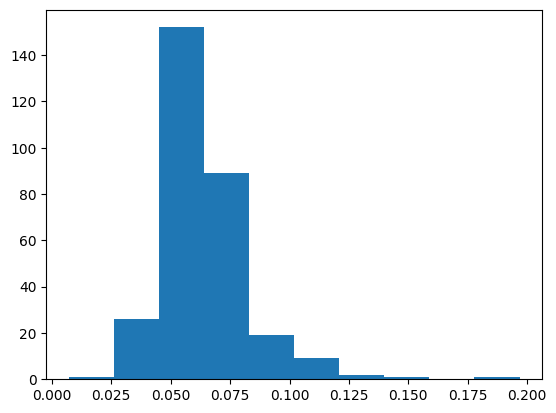

Stock Ticker:  61%|██████    | 300/492 [4:15:41<28:00,  8.75s/it]

company number:  301
Train RMSE: 0.013


Stock Ticker:  61%|██████    | 301/492 [4:15:50<28:03,  8.81s/it]

Test RMSE: 0.055
15350.702059268951
company number:  302
Train RMSE: 0.013


Stock Ticker:  61%|██████▏   | 302/492 [4:15:57<26:16,  8.30s/it]

Test RMSE: 0.070
15357.787199735641
company number:  303
Train RMSE: 0.020


Stock Ticker:  62%|██████▏   | 303/492 [4:16:05<25:50,  8.20s/it]

Test RMSE: 0.116
15365.770009994507
company number:  304
Train RMSE: 0.012


Stock Ticker:  62%|██████▏   | 304/492 [4:16:15<26:42,  8.52s/it]

Test RMSE: 0.054
15375.037538051605
company number:  305
Train RMSE: 0.007


Stock Ticker:  62%|██████▏   | 305/492 [4:16:23<26:43,  8.57s/it]

Test RMSE: 0.052
15383.737112998962
company number:  306
Train RMSE: 0.036


Stock Ticker:  62%|██████▏   | 306/492 [4:16:32<26:42,  8.62s/it]

Test RMSE: 0.052
15392.452644109726
company number:  307
Train RMSE: 0.019


Stock Ticker:  62%|██████▏   | 307/492 [4:16:40<25:59,  8.43s/it]

Test RMSE: 0.077
15400.449194192886
company number:  308
Train RMSE: 0.010


Stock Ticker:  63%|██████▎   | 308/492 [4:16:49<26:46,  8.73s/it]

Test RMSE: 0.056
15409.871309041977
company number:  309
Train RMSE: 0.020


Stock Ticker:  63%|██████▎   | 309/492 [4:17:00<28:42,  9.41s/it]

Test RMSE: 0.043
15420.888262987137
company number:  310
Train RMSE: 0.017


Stock Ticker:  63%|██████▎   | 310/492 [4:17:10<28:23,  9.36s/it]

Test RMSE: 0.074
15430.128105163574
company number:  311
Train RMSE: 0.018


Stock Ticker:  63%|██████▎   | 311/492 [4:17:19<27:48,  9.22s/it]

Test RMSE: 0.069
15439.015097379684
company number:  312
Train RMSE: 0.011


Stock Ticker:  63%|██████▎   | 312/492 [4:17:28<27:36,  9.20s/it]

Test RMSE: 0.037
15448.178020238876
company number:  313
Train RMSE: 0.012


Stock Ticker:  64%|██████▎   | 313/492 [4:17:36<26:31,  8.89s/it]

Test RMSE: 0.046
15456.333641767502
company number:  314
Train RMSE: 0.031


Stock Ticker:  64%|██████▍   | 314/492 [4:17:40<22:09,  7.47s/it]

Test RMSE: 0.076
15460.484094142914
company number:  315
Train RMSE: 0.024


Stock Ticker:  64%|██████▍   | 315/492 [4:17:49<23:07,  7.84s/it]

Test RMSE: 0.037
15469.187671422958
company number:  316
Train RMSE: 0.030


Stock Ticker:  64%|██████▍   | 316/492 [4:17:59<24:53,  8.49s/it]

Test RMSE: 0.058
15479.188235521317
company number:  317
Train RMSE: 0.016


Stock Ticker:  64%|██████▍   | 317/492 [4:18:09<26:42,  9.16s/it]

Test RMSE: 0.051
15489.904383659363
company number:  318
Train RMSE: 0.010


Stock Ticker:  65%|██████▍   | 318/492 [4:18:18<26:22,  9.10s/it]

Test RMSE: 0.054
15498.860704421997
company number:  319
Train RMSE: 0.016


Stock Ticker:  65%|██████▍   | 319/492 [4:18:28<26:26,  9.17s/it]

Test RMSE: 0.071
15508.211095809937
company number:  320
Train RMSE: 0.021


Stock Ticker:  65%|██████▌   | 320/492 [4:18:36<25:09,  8.78s/it]

Test RMSE: 0.067
15516.067568063736
company number:  321
Train RMSE: 0.010


Stock Ticker:  65%|██████▌   | 321/492 [4:18:44<24:54,  8.74s/it]

Test RMSE: 0.046
15524.719365358353
company number:  322
Train RMSE: 0.015


Stock Ticker:  65%|██████▌   | 322/492 [4:18:53<25:01,  8.83s/it]

Test RMSE: 0.055
15533.771755218506
company number:  323
Train RMSE: 0.012


Stock Ticker:  66%|██████▌   | 323/492 [4:19:02<25:07,  8.92s/it]

Test RMSE: 0.054
15542.889521360397
company number:  324
Train RMSE: 0.008


Stock Ticker:  66%|██████▌   | 324/492 [4:19:12<25:11,  9.00s/it]

Test RMSE: 0.060
15552.070484161377
company number:  325
Train RMSE: 0.009


Stock Ticker:  66%|██████▌   | 325/492 [4:19:22<26:05,  9.38s/it]

Test RMSE: 0.061
15562.33375287056
company number:  326
Train RMSE: 0.010


Stock Ticker:  66%|██████▋   | 326/492 [4:19:31<25:59,  9.40s/it]

Test RMSE: 0.077
15571.773379325867
company number:  327
Train RMSE: 0.016


Stock Ticker:  66%|██████▋   | 327/492 [4:19:41<25:49,  9.39s/it]

Test RMSE: 0.044
15581.148923635483
company number:  328
Train RMSE: 0.023


Stock Ticker:  67%|██████▋   | 328/492 [4:19:48<24:20,  8.91s/it]

Test RMSE: 0.062
15588.925453186035
company number:  329
Train RMSE: 0.017


Stock Ticker:  67%|██████▋   | 329/492 [4:19:58<25:01,  9.21s/it]

Test RMSE: 0.067
15598.841520309448
company number:  330
Train RMSE: 0.023


Stock Ticker:  67%|██████▋   | 330/492 [4:20:07<24:28,  9.06s/it]

Test RMSE: 0.065
15607.56525349617
company number:  331
Train RMSE: 0.024


Stock Ticker:  67%|██████▋   | 331/492 [4:20:17<25:01,  9.32s/it]

Test RMSE: 0.063
15617.4972615242
company number:  332
Train RMSE: 0.011


Stock Ticker:  67%|██████▋   | 332/492 [4:20:25<23:59,  9.00s/it]

Test RMSE: 0.048
15625.729393959045
company number:  333
Train RMSE: 0.020


Stock Ticker:  68%|██████▊   | 333/492 [4:20:35<24:10,  9.12s/it]

Test RMSE: 0.055
15635.14344716072
company number:  334
Train RMSE: 0.027


Stock Ticker:  68%|██████▊   | 334/492 [4:20:43<23:19,  8.86s/it]

Test RMSE: 0.068
15643.377358675003
company number:  335
Train RMSE: 0.013


Stock Ticker:  68%|██████▊   | 335/492 [4:20:52<23:37,  9.03s/it]

Test RMSE: 0.063
15652.816756725311
company number:  336
Train RMSE: 0.013


Stock Ticker:  68%|██████▊   | 336/492 [4:21:01<23:30,  9.04s/it]

Test RMSE: 0.064
15661.894125699997
company number:  337
Train RMSE: 0.015


Stock Ticker:  68%|██████▊   | 337/492 [4:21:11<23:38,  9.15s/it]

Test RMSE: 0.071
15671.305681705475
company number:  338
Train RMSE: 0.016


Stock Ticker:  69%|██████▊   | 338/492 [4:21:20<23:40,  9.23s/it]

Test RMSE: 0.058
15680.696764945984
company number:  339
Train RMSE: 0.027


Stock Ticker:  69%|██████▉   | 339/492 [4:21:29<23:17,  9.13s/it]

Test RMSE: 0.074
15689.608231544495
company number:  340
Train RMSE: 0.021


Stock Ticker:  69%|██████▉   | 340/492 [4:21:39<23:20,  9.21s/it]

Test RMSE: 0.064
15699.01320719719
company number:  341
Train RMSE: 0.025


Stock Ticker:  69%|██████▉   | 341/492 [4:21:48<23:24,  9.30s/it]

Test RMSE: 0.074
15708.515059709549
company number:  342
Train RMSE: 0.016


Stock Ticker:  70%|██████▉   | 342/492 [4:21:58<23:31,  9.41s/it]

Test RMSE: 0.045
15718.181851625443
company number:  343
Train RMSE: 0.020


Stock Ticker:  70%|██████▉   | 343/492 [4:22:09<25:05, 10.11s/it]

Test RMSE: 0.074
15729.91156578064
company number:  344
Train RMSE: 0.017


Stock Ticker:  70%|██████▉   | 344/492 [4:22:20<25:15, 10.24s/it]

Test RMSE: 0.062
15740.473048686981
company number:  345
Train RMSE: 0.007


Stock Ticker:  70%|███████   | 345/492 [4:22:29<24:16,  9.91s/it]

Test RMSE: 0.051
15749.59603357315
company number:  346
Train RMSE: 0.015


Stock Ticker:  70%|███████   | 346/492 [4:26:11<2:58:51, 73.51s/it]

Test RMSE: 0.037
15971.500121593475
company number:  347
Train RMSE: 0.012


Stock Ticker:  71%|███████   | 347/492 [4:30:47<5:24:14, 134.17s/it]

Test RMSE: 0.058
16247.214087963104
company number:  348
Train RMSE: 0.047


Stock Ticker:  71%|███████   | 348/492 [4:35:54<7:26:19, 185.97s/it]

Test RMSE: 0.103
16554.044526576996
company number:  349
Train RMSE: 0.013


Stock Ticker:  71%|███████   | 349/492 [4:40:49<8:41:17, 218.72s/it]

Test RMSE: 0.078
16849.19686961174
company number:  350
Train RMSE: 0.019
Test RMSE: 0.058
17157.49538254738


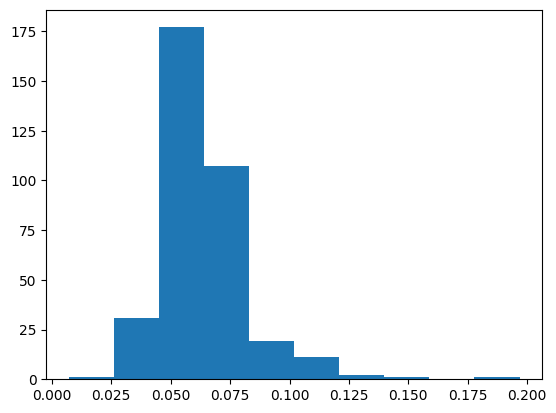

Stock Ticker:  71%|███████   | 350/492 [4:45:57<9:41:20, 245.64s/it]

company number:  351
Train RMSE: 0.015


Stock Ticker:  71%|███████▏  | 351/492 [4:50:11<9:43:16, 248.20s/it]

Test RMSE: 0.075
17411.826509714127
company number:  352
Train RMSE: 0.013


Stock Ticker:  72%|███████▏  | 352/492 [4:55:03<10:09:32, 261.24s/it]

Test RMSE: 0.068
17703.46933555603
company number:  353
Train RMSE: 0.016


Stock Ticker:  72%|███████▏  | 353/492 [4:58:24<9:23:15, 243.13s/it] 

Test RMSE: 0.059
17904.3615193367
company number:  354
Train RMSE: 0.023


Stock Ticker:  72%|███████▏  | 354/492 [4:58:36<6:39:38, 173.76s/it]

Test RMSE: 0.096
17916.237348794937
company number:  355
Train RMSE: 0.017


Stock Ticker:  72%|███████▏  | 355/492 [4:58:46<4:44:40, 124.67s/it]

Test RMSE: 0.055
17926.388056516647
company number:  356
Train RMSE: 0.022


Stock Ticker:  72%|███████▏  | 356/492 [4:58:55<3:24:09, 90.07s/it] 

Test RMSE: 0.091
17935.704398870468
company number:  357
Train RMSE: 0.009


Stock Ticker:  73%|███████▎  | 357/492 [4:59:04<2:27:47, 65.69s/it]

Test RMSE: 0.051
17944.504890680313
company number:  358
Train RMSE: 0.013


Stock Ticker:  73%|███████▎  | 358/492 [4:59:13<1:48:42, 48.68s/it]

Test RMSE: 0.064
17953.49407196045
company number:  359
Train RMSE: 0.014


Stock Ticker:  73%|███████▎  | 359/492 [4:59:22<1:21:43, 36.87s/it]

Test RMSE: 0.070
17962.80659031868
company number:  360
Train RMSE: 0.020


Stock Ticker:  73%|███████▎  | 360/492 [4:59:32<1:02:58, 28.63s/it]

Test RMSE: 0.071
17972.20492219925
company number:  361
Train RMSE: 0.016


Stock Ticker:  73%|███████▎  | 361/492 [4:59:42<50:24, 23.09s/it]  

Test RMSE: 0.045
17982.3594789505
company number:  362
Train RMSE: 0.019


Stock Ticker:  74%|███████▎  | 362/492 [4:59:52<41:40, 19.23s/it]

Test RMSE: 0.059
17992.600538492203
company number:  363
Train RMSE: 0.032


Stock Ticker:  74%|███████▍  | 363/492 [5:00:36<57:30, 26.74s/it]

Test RMSE: 0.034
18036.87390089035
company number:  364
Train RMSE: 0.017


Stock Ticker:  74%|███████▍  | 364/492 [5:00:45<45:44, 21.44s/it]

Test RMSE: 0.044
18045.93681526184
company number:  365
Train RMSE: 0.020


Stock Ticker:  74%|███████▍  | 365/492 [5:01:52<1:13:58, 34.95s/it]

Test RMSE: 0.057
18112.399353981018
company number:  366
Train RMSE: 0.017


Stock Ticker:  74%|███████▍  | 366/492 [5:03:42<2:00:49, 57.53s/it]

Test RMSE: 0.070
18222.631048202515
company number:  367
Train RMSE: 0.018


Stock Ticker:  75%|███████▍  | 367/492 [5:03:52<1:29:46, 43.09s/it]

Test RMSE: 0.062
18232.01907992363
company number:  368
Train RMSE: 0.019


Stock Ticker:  75%|███████▍  | 368/492 [5:04:02<1:08:39, 33.22s/it]

Test RMSE: 0.057
18242.20773911476
company number:  369
Train RMSE: 0.009


Stock Ticker:  75%|███████▌  | 369/492 [5:04:10<52:55, 25.82s/it]  

Test RMSE: 0.081
18250.749628305435
company number:  370
Train RMSE: 0.014


Stock Ticker:  75%|███████▌  | 370/492 [5:04:20<42:56, 21.12s/it]

Test RMSE: 0.071
18260.91401076317
company number:  371
Train RMSE: 0.017


Stock Ticker:  75%|███████▌  | 371/492 [5:04:28<34:34, 17.14s/it]

Test RMSE: 0.074
18268.771061182022
company number:  372
Train RMSE: 0.021


Stock Ticker:  76%|███████▌  | 372/492 [5:04:38<29:47, 14.90s/it]

Test RMSE: 0.074
18278.42889356613
company number:  373
Train RMSE: 0.009


Stock Ticker:  76%|███████▌  | 373/492 [5:04:47<25:58, 13.10s/it]

Test RMSE: 0.045
18287.33127593994
company number:  374
Train RMSE: 0.016


Stock Ticker:  76%|███████▌  | 374/492 [5:04:55<23:06, 11.75s/it]

Test RMSE: 0.078
18295.93078827858
company number:  375
Train RMSE: 0.009


Stock Ticker:  76%|███████▌  | 375/492 [5:05:03<20:37, 10.58s/it]

Test RMSE: 0.055
18303.768037080765
company number:  376
Train RMSE: 0.018


Stock Ticker:  76%|███████▋  | 376/492 [5:05:11<19:01,  9.84s/it]

Test RMSE: 0.068
18311.889961242676
company number:  377
Train RMSE: 0.019


Stock Ticker:  77%|███████▋  | 377/492 [5:05:20<18:03,  9.42s/it]

Test RMSE: 0.055
18320.335245847702
company number:  378
Train RMSE: 0.023


Stock Ticker:  77%|███████▋  | 378/492 [5:05:32<19:13, 10.12s/it]

Test RMSE: 0.049
18332.074808597565
company number:  379
Train RMSE: 0.012


Stock Ticker:  77%|███████▋  | 379/492 [5:05:39<17:28,  9.28s/it]

Test RMSE: 0.072
18339.40461397171
company number:  380
Train RMSE: 0.021


Stock Ticker:  77%|███████▋  | 380/492 [5:05:53<19:52, 10.64s/it]

Test RMSE: 0.052
18353.230269908905
company number:  381
Train RMSE: 0.012


Stock Ticker:  77%|███████▋  | 381/492 [5:06:01<18:21,  9.92s/it]

Test RMSE: 0.075
18361.464290618896
company number:  382
Train RMSE: 0.012


Stock Ticker:  78%|███████▊  | 382/492 [5:06:10<17:46,  9.70s/it]

Test RMSE: 0.072
18370.639672756195
company number:  383
Train RMSE: 0.019


Stock Ticker:  78%|███████▊  | 383/492 [5:06:20<17:49,  9.81s/it]

Test RMSE: 0.069
18380.71420621872
company number:  384
Train RMSE: 0.020


Stock Ticker:  78%|███████▊  | 384/492 [5:06:30<17:30,  9.73s/it]

Test RMSE: 0.052
18390.25575685501
company number:  385
Train RMSE: 0.015


Stock Ticker:  78%|███████▊  | 385/492 [5:06:39<16:51,  9.46s/it]

Test RMSE: 0.084
18399.073798179626
company number:  386
Train RMSE: 0.020


Stock Ticker:  78%|███████▊  | 386/492 [5:06:48<16:38,  9.42s/it]

Test RMSE: 0.060
18408.40766453743
company number:  387
Train RMSE: 0.014


Stock Ticker:  79%|███████▊  | 387/492 [5:06:56<16:01,  9.16s/it]

Test RMSE: 0.055
18416.96230363846
company number:  388
Train RMSE: 0.012


Stock Ticker:  79%|███████▉  | 388/492 [5:07:09<17:36, 10.16s/it]

Test RMSE: 0.046
18429.456073999405
company number:  389
Train RMSE: 0.025


Stock Ticker:  79%|███████▉  | 389/492 [5:07:19<17:20, 10.10s/it]

Test RMSE: 0.093
18439.417050123215
company number:  390
Train RMSE: 0.019


Stock Ticker:  79%|███████▉  | 390/492 [5:07:27<16:16,  9.58s/it]

Test RMSE: 0.063
18447.76670026779
company number:  391
Train RMSE: 0.016


Stock Ticker:  79%|███████▉  | 391/492 [5:07:36<15:48,  9.39s/it]

Test RMSE: 0.058
18456.728844165802
company number:  392
Train RMSE: 0.014


Stock Ticker:  80%|███████▉  | 392/492 [5:07:45<15:27,  9.27s/it]

Test RMSE: 0.055
18465.71943616867
company number:  393
Train RMSE: 0.011


Stock Ticker:  80%|███████▉  | 393/492 [5:07:55<15:27,  9.37s/it]

Test RMSE: 0.074
18475.305230140686
company number:  394
Train RMSE: 0.022


Stock Ticker:  80%|████████  | 394/492 [5:08:03<14:54,  9.13s/it]

Test RMSE: 0.078
18483.89012670517
company number:  395
Train RMSE: 0.017


Stock Ticker:  80%|████████  | 395/492 [5:08:11<14:15,  8.82s/it]

Test RMSE: 0.054
18491.971824645996
company number:  396
Train RMSE: 0.017


Stock Ticker:  80%|████████  | 396/492 [5:08:19<13:41,  8.56s/it]

Test RMSE: 0.098
18499.918127775192
company number:  397
Train RMSE: 0.018


Stock Ticker:  81%|████████  | 397/492 [5:08:28<13:46,  8.70s/it]

Test RMSE: 0.075
18508.96910572052
company number:  398
Train RMSE: 0.011


Stock Ticker:  81%|████████  | 398/492 [5:08:38<13:49,  8.82s/it]

Test RMSE: 0.060
18518.060322999954
company number:  399
Train RMSE: 0.018


Stock Ticker:  81%|████████  | 399/492 [5:08:47<13:56,  8.99s/it]

Test RMSE: 0.057
18527.445115327835
company number:  400
Train RMSE: 0.025
Test RMSE: 0.072
18536.159108877182


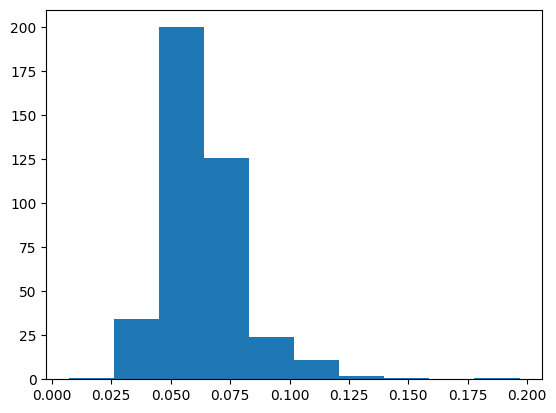

Stock Ticker:  81%|████████▏ | 400/492 [5:08:56<13:41,  8.93s/it]

company number:  401
Train RMSE: 0.008


Stock Ticker:  82%|████████▏ | 401/492 [5:09:05<13:38,  8.99s/it]

Test RMSE: 0.054
18545.369787216187
company number:  402
Train RMSE: 0.022


Stock Ticker:  82%|████████▏ | 402/492 [5:09:13<12:55,  8.61s/it]

Test RMSE: 0.070
18553.093293905258
company number:  403
Train RMSE: 0.009


Stock Ticker:  82%|████████▏ | 403/492 [5:09:25<14:26,  9.74s/it]

Test RMSE: 0.066
18565.463064432144
company number:  404
Train RMSE: 0.009


Stock Ticker:  82%|████████▏ | 404/492 [5:09:33<13:34,  9.25s/it]

Test RMSE: 0.037
18573.5774204731
company number:  405
Train RMSE: 0.021


Stock Ticker:  82%|████████▏ | 405/492 [5:09:42<13:16,  9.16s/it]

Test RMSE: 0.061
18582.519900083542
company number:  406
Train RMSE: 0.039


Stock Ticker:  83%|████████▎ | 406/492 [5:10:04<18:48, 13.12s/it]

Test RMSE: 0.053
18604.872804641724
company number:  407
Train RMSE: 0.010


Stock Ticker:  83%|████████▎ | 407/492 [5:10:12<16:22, 11.56s/it]

Test RMSE: 0.082
18612.79701757431
company number:  408
Train RMSE: 0.012


Stock Ticker:  83%|████████▎ | 408/492 [5:10:22<15:36, 11.15s/it]

Test RMSE: 0.056
18622.9791431427
company number:  409
Train RMSE: 0.018


Stock Ticker:  83%|████████▎ | 409/492 [5:10:32<14:42, 10.63s/it]

Test RMSE: 0.078
18632.42071247101
company number:  410
Train RMSE: 0.007


Stock Ticker:  83%|████████▎ | 410/492 [5:10:41<13:54, 10.17s/it]

Test RMSE: 0.057
18641.515592336655
company number:  411
Train RMSE: 0.027


Stock Ticker:  84%|████████▎ | 411/492 [5:10:53<14:17, 10.59s/it]

Test RMSE: 0.059
18653.065760850906
company number:  412
Train RMSE: 0.037


Stock Ticker:  84%|████████▎ | 412/492 [5:11:01<13:20, 10.01s/it]

Test RMSE: 0.074
18661.738827943802
company number:  413
Train RMSE: 0.010


Stock Ticker:  84%|████████▍ | 413/492 [5:11:10<12:42,  9.65s/it]

Test RMSE: 0.052
18670.53404688835
company number:  414
Train RMSE: 0.024


Stock Ticker:  84%|████████▍ | 414/492 [5:11:19<12:05,  9.30s/it]

Test RMSE: 0.062
18679.037260770798
company number:  415
Train RMSE: 0.016


Stock Ticker:  84%|████████▍ | 415/492 [5:11:28<11:56,  9.30s/it]

Test RMSE: 0.086
18688.32882785797
company number:  416
Train RMSE: 0.008


Stock Ticker:  85%|████████▍ | 416/492 [5:11:37<11:33,  9.12s/it]

Test RMSE: 0.038
18697.03067612648
company number:  417
Train RMSE: 0.012


Stock Ticker:  85%|████████▍ | 417/492 [5:11:45<11:20,  9.08s/it]

Test RMSE: 0.040
18705.999758958817
company number:  418
Train RMSE: 0.017


Stock Ticker:  85%|████████▍ | 418/492 [5:11:56<11:53,  9.64s/it]

Test RMSE: 0.047
18716.963917970657
company number:  419
Train RMSE: 0.009


Stock Ticker:  85%|████████▌ | 419/492 [5:12:05<11:22,  9.35s/it]

Test RMSE: 0.063
18725.629383563995
company number:  420
Train RMSE: 0.030


Stock Ticker:  85%|████████▌ | 420/492 [5:12:20<13:13, 11.02s/it]

Test RMSE: 0.069
18740.556319475174
company number:  421
Train RMSE: 0.022


Stock Ticker:  86%|████████▌ | 421/492 [5:12:28<11:56, 10.10s/it]

Test RMSE: 0.045
18748.496318101883
company number:  422
Train RMSE: 0.023


Stock Ticker:  86%|████████▌ | 422/492 [5:12:37<11:33,  9.90s/it]

Test RMSE: 0.047
18757.947457313538
company number:  423
Train RMSE: 0.009


Stock Ticker:  86%|████████▌ | 423/492 [5:12:46<10:52,  9.46s/it]

Test RMSE: 0.065
18766.35889840126
company number:  424
Train RMSE: 0.016


Stock Ticker:  86%|████████▌ | 424/492 [5:12:54<10:16,  9.06s/it]

Test RMSE: 0.038
18774.506853342056
company number:  425
Train RMSE: 0.021


Stock Ticker:  86%|████████▋ | 425/492 [5:13:04<10:22,  9.29s/it]

Test RMSE: 0.057
18784.32750415802
company number:  426
Train RMSE: 0.013


Stock Ticker:  87%|████████▋ | 426/492 [5:13:13<10:11,  9.27s/it]

Test RMSE: 0.068
18793.544154405594
company number:  427
Train RMSE: 0.027


Stock Ticker:  87%|████████▋ | 427/492 [5:13:24<10:36,  9.79s/it]

Test RMSE: 0.074
18804.56582212448
company number:  428
Train RMSE: 0.009


Stock Ticker:  87%|████████▋ | 428/492 [5:13:32<09:52,  9.26s/it]

Test RMSE: 0.027
18812.56860280037
company number:  429
Train RMSE: 0.022


Stock Ticker:  87%|████████▋ | 429/492 [5:13:43<10:15,  9.77s/it]

Test RMSE: 0.062
18823.533844470978
company number:  430
Train RMSE: 0.011


Stock Ticker:  87%|████████▋ | 430/492 [5:13:53<10:05,  9.77s/it]

Test RMSE: 0.062
18833.31877708435
company number:  431
Train RMSE: 0.011


Stock Ticker:  88%|████████▊ | 431/492 [5:14:02<09:45,  9.60s/it]

Test RMSE: 0.066
18842.52453994751
company number:  432
Train RMSE: 0.008


Stock Ticker:  88%|████████▊ | 432/492 [5:14:12<09:35,  9.59s/it]

Test RMSE: 0.047
18852.092554569244
company number:  433
Train RMSE: 0.016


Stock Ticker:  88%|████████▊ | 433/492 [5:14:21<09:22,  9.53s/it]

Test RMSE: 0.071
18861.460815668106
company number:  434
Train RMSE: 0.006


Stock Ticker:  88%|████████▊ | 434/492 [5:14:29<08:43,  9.02s/it]

Test RMSE: 0.047
18869.314053058624
company number:  435
Train RMSE: 0.023


Stock Ticker:  88%|████████▊ | 435/492 [5:14:38<08:35,  9.05s/it]

Test RMSE: 0.073
18878.414672136307
company number:  436
Train RMSE: 0.018


Stock Ticker:  89%|████████▊ | 436/492 [5:14:46<08:11,  8.78s/it]

Test RMSE: 0.083
18886.56677031517
company number:  437
Train RMSE: 0.017


Stock Ticker:  89%|████████▉ | 437/492 [5:14:55<08:12,  8.95s/it]

Test RMSE: 0.052
18895.932079792023
company number:  438
Train RMSE: 0.009


Stock Ticker:  89%|████████▉ | 438/492 [5:15:05<08:12,  9.12s/it]

Test RMSE: 0.068
18905.436450004578
company number:  439
Train RMSE: 0.017


Stock Ticker:  89%|████████▉ | 439/492 [5:15:15<08:20,  9.45s/it]

Test RMSE: 0.060
18915.665662288666
company number:  440
Train RMSE: 0.008


Stock Ticker:  89%|████████▉ | 440/492 [5:15:24<08:07,  9.38s/it]

Test RMSE: 0.050
18924.867275476456
company number:  441
Train RMSE: 0.014


Stock Ticker:  90%|████████▉ | 441/492 [5:15:36<08:30, 10.00s/it]

Test RMSE: 0.049
18936.326917886734
company number:  442
Train RMSE: 0.008


Stock Ticker:  90%|████████▉ | 442/492 [5:15:45<08:01,  9.63s/it]

Test RMSE: 0.051
18945.088327884674
company number:  443
Train RMSE: 0.022


Stock Ticker:  90%|█████████ | 443/492 [5:15:54<07:45,  9.50s/it]

Test RMSE: 0.087
18954.270324468613
company number:  444
Train RMSE: 0.021


Stock Ticker:  90%|█████████ | 444/492 [5:16:03<07:31,  9.40s/it]

Test RMSE: 0.065
18963.454998016357
company number:  445
Train RMSE: 0.017


Stock Ticker:  90%|█████████ | 445/492 [5:16:12<07:23,  9.44s/it]

Test RMSE: 0.080
18972.98855471611
company number:  446
Train RMSE: 0.014


Stock Ticker:  91%|█████████ | 446/492 [5:16:20<06:41,  8.73s/it]

Test RMSE: 0.046
18980.04195189476
company number:  447
Train RMSE: 0.012


Stock Ticker:  91%|█████████ | 447/492 [5:16:30<06:54,  9.22s/it]

Test RMSE: 0.065
18990.406020879745
company number:  448
Train RMSE: 0.016


Stock Ticker:  91%|█████████ | 448/492 [5:16:39<06:44,  9.19s/it]

Test RMSE: 0.062
18999.52866101265
company number:  449
Train RMSE: 0.049


Stock Ticker:  91%|█████████▏| 449/492 [5:16:41<04:57,  6.91s/it]

Test RMSE: 0.059
19001.132241010666
company number:  450
Train RMSE: 0.012
Test RMSE: 0.054
19010.274826526642


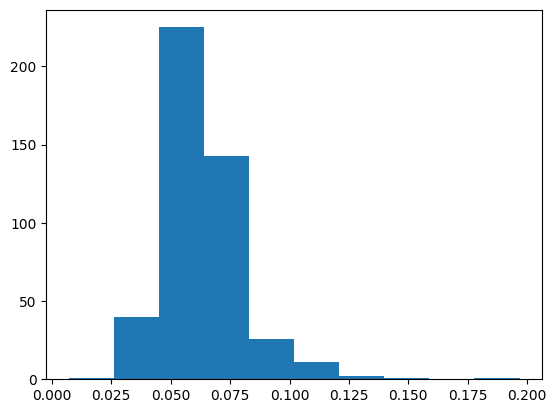

Stock Ticker:  91%|█████████▏| 450/492 [5:16:50<05:19,  7.60s/it]

company number:  451
Train RMSE: 0.017


Stock Ticker:  92%|█████████▏| 451/492 [5:16:59<05:30,  8.05s/it]

Test RMSE: 0.066
19019.436600208282
company number:  452
Train RMSE: 0.016


Stock Ticker:  92%|█████████▏| 452/492 [5:17:08<05:38,  8.45s/it]

Test RMSE: 0.090
19028.828503131866
company number:  453
Train RMSE: 0.020


Stock Ticker:  92%|█████████▏| 453/492 [5:17:16<05:16,  8.12s/it]

Test RMSE: 0.063
19036.163514614105
company number:  454
Train RMSE: 0.018


Stock Ticker:  92%|█████████▏| 454/492 [5:17:24<05:09,  8.14s/it]

Test RMSE: 0.082
19044.34544277191
company number:  455
Train RMSE: 0.015


Stock Ticker:  92%|█████████▏| 455/492 [5:17:32<05:02,  8.19s/it]

Test RMSE: 0.060
19052.653212308884
company number:  456
Train RMSE: 0.016


Stock Ticker:  93%|█████████▎| 456/492 [5:17:41<04:57,  8.27s/it]

Test RMSE: 0.088
19061.103305101395
company number:  457
Train RMSE: 0.020


Stock Ticker:  93%|█████████▎| 457/492 [5:17:49<04:52,  8.35s/it]

Test RMSE: 0.073
19069.635048866272
company number:  458
Train RMSE: 0.015


Stock Ticker:  93%|█████████▎| 458/492 [5:17:57<04:36,  8.15s/it]

Test RMSE: 0.047
19077.31096792221
company number:  459
Train RMSE: 0.012


Stock Ticker:  93%|█████████▎| 459/492 [5:18:06<04:34,  8.32s/it]

Test RMSE: 0.074
19086.04239678383
company number:  460
Train RMSE: 0.013


Stock Ticker:  93%|█████████▎| 460/492 [5:18:14<04:26,  8.32s/it]

Test RMSE: 0.047
19094.358280420303
company number:  461
Train RMSE: 0.009


Stock Ticker:  94%|█████████▎| 461/492 [5:18:23<04:29,  8.68s/it]

Test RMSE: 0.053
19103.883244752884
company number:  462
Train RMSE: 0.026


Stock Ticker:  94%|█████████▍| 462/492 [5:18:33<04:30,  9.02s/it]

Test RMSE: 0.053
19113.69436597824
company number:  463
Train RMSE: 0.022


Stock Ticker:  94%|█████████▍| 463/492 [5:18:41<04:09,  8.61s/it]

Test RMSE: 0.069
19121.349922418594
company number:  464
Train RMSE: 0.009


Stock Ticker:  94%|█████████▍| 464/492 [5:18:48<03:45,  8.05s/it]

Test RMSE: 0.035
19128.096585989
company number:  465
Train RMSE: 0.012


Stock Ticker:  95%|█████████▍| 465/492 [5:18:57<03:45,  8.33s/it]

Test RMSE: 0.061
19137.088200092316
company number:  466
Train RMSE: 0.013


Stock Ticker:  95%|█████████▍| 466/492 [5:19:06<03:48,  8.79s/it]

Test RMSE: 0.052
19146.930503845215
company number:  467
Train RMSE: 0.014


Stock Ticker:  95%|█████████▍| 467/492 [5:19:16<03:42,  8.90s/it]

Test RMSE: 0.044
19156.098885774612
company number:  468
Train RMSE: 0.009


Stock Ticker:  95%|█████████▌| 468/492 [5:19:25<03:34,  8.92s/it]

Test RMSE: 0.064
19165.054448604584
company number:  469
Train RMSE: 0.016


Stock Ticker:  95%|█████████▌| 469/492 [5:19:34<03:27,  9.02s/it]

Test RMSE: 0.047
19174.304871320724
company number:  470
Train RMSE: 0.015


Stock Ticker:  96%|█████████▌| 470/492 [5:19:42<03:14,  8.83s/it]

Test RMSE: 0.051
19182.7065448761
company number:  471
Train RMSE: 0.017


Stock Ticker:  96%|█████████▌| 471/492 [5:19:51<03:07,  8.92s/it]

Test RMSE: 0.042
19191.841520547867
company number:  472
Train RMSE: 0.011


Stock Ticker:  96%|█████████▌| 472/492 [5:20:00<02:55,  8.78s/it]

Test RMSE: 0.068
19200.284049749374
company number:  473
Train RMSE: 0.029


Stock Ticker:  96%|█████████▌| 473/492 [5:20:08<02:44,  8.64s/it]

Test RMSE: 0.084
19208.613535642624
company number:  474
Train RMSE: 0.010


Stock Ticker:  96%|█████████▋| 474/492 [5:20:17<02:36,  8.67s/it]

Test RMSE: 0.055
19217.334666252136
company number:  475
Train RMSE: 0.033


Stock Ticker:  97%|█████████▋| 475/492 [5:20:26<02:29,  8.81s/it]

Test RMSE: 0.077
19226.46176314354
company number:  476
Train RMSE: 0.011


Stock Ticker:  97%|█████████▋| 476/492 [5:20:37<02:32,  9.52s/it]

Test RMSE: 0.040
19237.648471832275
company number:  477
Train RMSE: 0.022


Stock Ticker:  97%|█████████▋| 477/492 [5:20:47<02:24,  9.61s/it]

Test RMSE: 0.069
19247.466380357742
company number:  478
Train RMSE: 0.011


Stock Ticker:  97%|█████████▋| 478/492 [5:20:55<02:09,  9.28s/it]

Test RMSE: 0.051
19255.993439674377
company number:  479
Train RMSE: 0.008


Stock Ticker:  97%|█████████▋| 479/492 [5:21:05<02:00,  9.24s/it]

Test RMSE: 0.049
19265.117471456528
company number:  480
Train RMSE: 0.011


Stock Ticker:  98%|█████████▊| 480/492 [5:21:14<01:52,  9.37s/it]

Test RMSE: 0.048
19274.81036710739
company number:  481
Train RMSE: 0.014


Stock Ticker:  98%|█████████▊| 481/492 [5:21:24<01:45,  9.61s/it]

Test RMSE: 0.039
19284.98009467125
company number:  482
Train RMSE: 0.017


Stock Ticker:  98%|█████████▊| 482/492 [5:21:36<01:41, 10.13s/it]

Test RMSE: 0.037
19296.31379532814
company number:  483
Train RMSE: 0.017


Stock Ticker:  98%|█████████▊| 483/492 [5:21:45<01:28,  9.79s/it]

Test RMSE: 0.051
19305.300558567047
company number:  484
Train RMSE: 0.011


Stock Ticker:  98%|█████████▊| 484/492 [5:21:54<01:17,  9.64s/it]

Test RMSE: 0.060
19314.605496644974
company number:  485
Train RMSE: 0.021


Stock Ticker:  99%|█████████▊| 485/492 [5:22:02<01:03,  9.13s/it]

Test RMSE: 0.074
19322.528388738632
company number:  486
Train RMSE: 0.015


Stock Ticker:  99%|█████████▉| 486/492 [5:22:11<00:53,  8.99s/it]

Test RMSE: 0.048
19331.184762001038
company number:  487
Train RMSE: 0.011


Stock Ticker:  99%|█████████▉| 487/492 [5:22:19<00:43,  8.65s/it]

Test RMSE: 0.049
19339.046008348465
company number:  488
Train RMSE: 0.023


Stock Ticker:  99%|█████████▉| 488/492 [5:22:28<00:35,  8.78s/it]

Test RMSE: 0.107
19348.140796661377
company number:  489
Train RMSE: 0.010


Stock Ticker:  99%|█████████▉| 489/492 [5:22:36<00:26,  8.70s/it]

Test RMSE: 0.061
19356.657188653946
company number:  490
Train RMSE: 0.014


Stock Ticker: 100%|█████████▉| 490/492 [5:22:45<00:17,  8.80s/it]

Test RMSE: 0.068
19365.68000602722
company number:  491
Train RMSE: 0.017


Stock Ticker: 100%|█████████▉| 491/492 [5:22:55<00:08,  8.99s/it]

Test RMSE: 0.065
19375.133536577225
company number:  492
Train RMSE: 0.009


Stock Ticker: 100%|██████████| 492/492 [5:23:03<00:00, 39.40s/it]

Test RMSE: 0.058
19383.234894275665


In [7]:
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import time

# Suppress warnings
warnings.filterwarnings("ignore")

start_time = time.time()

# Define the order of the ARIMA model
order = (3,1,0)
train_rmse_list = []
test_rmse_list = [] 
i = 0                                                                                    

for stock_ticker in tqdm(test_tickers, desc="Stock Ticker"):
    i = i +1
    print("company number: ", i)
    stock_data = fetch_data_and_engineer_features(stock_ticker)
    stock_data = stock_data.drop(columns=['ticker'])
    scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
    stock_data_temp = scaler.fit_transform(stock_data)
    scaler = MinMaxScaler(feature_range=(-1, 1)).set_output(transform="pandas")
    scaler.fit(stock_data[['close']])
    stock_data = stock_data_temp

    # Load data
    x_train, y_train, x_test, y_test = load_data(stock_data, 61)

    history = [x for x in y_train]
    predictions = list()

    # walk-forward validation for training data
    train_predictions = []
    last_successful_prediction = None
    for t in range(len(y_train)):
        try:
            model = ARIMA(history[:t+1], order=order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            train_predictions.append(yhat)
            last_successful_prediction = yhat
        except:
            if last_successful_prediction is not None:
                train_predictions.append(last_successful_prediction)
            else:
                train_predictions.append(y_train[t-1] if t > 0 else y_train[t])

    # calculate training RMSE
    train_rmse = sqrt(mean_squared_error(y_train, train_predictions))
    print('Train RMSE: %.3f' % train_rmse)

    # walk-forward validation for test data
    for t in range(len(y_test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = y_test[t]
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))

    # calculate test RMSE
    test_rmse = math.sqrt(mean_squared_error(y_test, predictions))
    print('Test RMSE: %.3f' % test_rmse)

    test_rmse_list.append(test_rmse)
    print(time.time() - start_time)

    if i % 50 == 0:
        plt.hist(test_rmse_list)
        plt.savefig(f"ARIMA_0_to_{i}.png")
        plt.show()

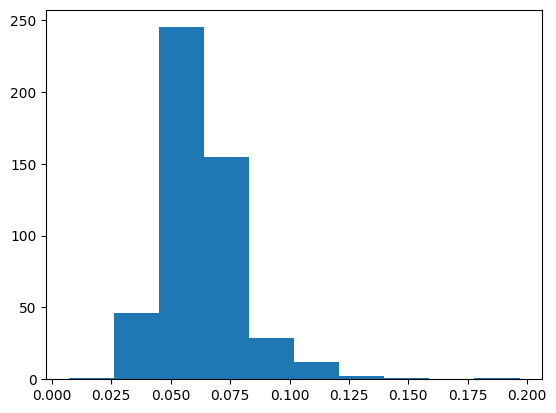

In [8]:
plt.hist(test_rmse_list)
plt.savefig("ARIMA.png")
plt.show()

In [15]:
import pandas as pd

# Assuming test_rmse_list, train_rmse_list, and test_tickers are lists of the same length
df = pd.DataFrame({
    'stock_ticker': test_tickers,
    #'train_rmse': train_rmse_list,
    'test_rmse': test_rmse_list,
})

# Create a new column 'test_rmse_x32' which is 'test_rmse' multiplied by 32
df['test_rmse_x492'] = df['test_rmse'] * 492

# Save the DataFrame to a CSV file
df.to_csv('rmse_values_492.csv', index=False)

# Print the statistics of the 'test_rmse_x492' column
print(df['test_rmse_x492'].describe())

count    492.000000
mean      31.022595
std        8.655164
min        3.480709
25%       25.368275
50%       29.828377
75%       35.418830
max       96.819275
Name: test_rmse_x492, dtype: float64


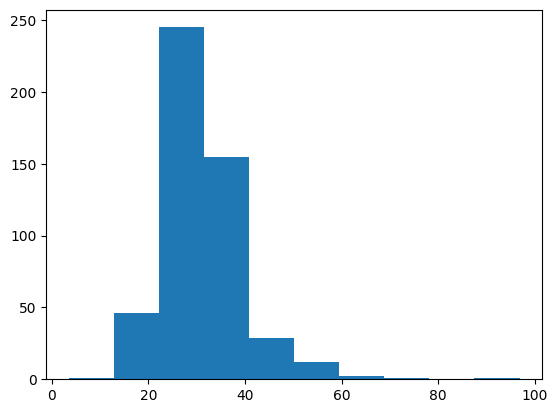

In [14]:
# extrapolating for the whole dataset of 492 companies
plt.hist([value * 492 for value in test_rmse_list])
plt.savefig("ARIMA_x492.png")
plt.show()